<a href="https://colab.research.google.com/github/enok/flowpredict/blob/main/flowpredict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Free Cash Flow Forecasting

<small><div style="text-align: right">The data will consist of quarterly reports spanning from 2011 to 2022 (12 years).</div></small>

### Mounting Google Drive (if is not running locally)

In [1]:
def is_running_in_colab():
    try:
        from google.colab import drive
        drive.mount('/content/gdrive', force_remount=True)
        %cd '/content/gdrive/MyDrive/cursos/usp/mba/data-science/tcc/code/flowpredict'
        return True
    except ImportError:
        return False

if is_running_in_colab():
    print("Running inside Google Colab!")
else:
    print("Not running inside Google Colab.")

Not running inside Google Colab.


## 1 Downloading and loading stock market data from the CVM website.

### 1.1 Companies to be analised


| Company       | Ticker    | CVM Code  |
| :---          | :----     | ----:     |
| Cemig         | CMIG4     | 2453      |
| Taesa         | TAEE11    | 20257     |

In [2]:
companies = {
    2453:  {"name": "Cemig", "ticker": "CMIG4"},
    20257: {"name": "Taesa", "ticker": "TAEE11"}
}

print(f'companies: {companies}\n')

companies: {2453: {'name': 'Cemig', 'ticker': 'CMIG4'}, 20257: {'name': 'Taesa', 'ticker': 'TAEE11'}}



### 1.2 Accounts selected

Based on:<br>
Investiment Valuation Tools and Techniques for Determining the Value of Any Asset (Aswath Damodaran)<br>
    CHAPTER 14 - Free Cash Flow to Equity Discount Models<br><br>

*Free Cash Flows to Equity (FCFE) = <br>
	Net income - (Capital expenditures - Depreciation) <br>
	- (Change in noncash working capital) <br>
	+ (New debt issued - Debt repayments)*<br><br>


*Fluxo de Caixa Livre para os Acionistas (FCLPA) = <br>
Lucro Líquido<br>
 \- (Investimentos em Ativos Fixos - Depreciação)<br>
 \- (Variação no Capital de Giro, excluindo Caixa)<br>
 \+ (Novas Dívidas Emitidas - Pagamentos de Dívida)*<br><br>

*FCFE = <br>
  3.11 (Lucro/Prejuizo Consolidado do Periodo do DRE)<br>
  \- (Δ 1.02.03 (Imobilizado) - 7.04.01 (Depreciacao, Amortizacao e Exaustao da DVA))<br>
  \- (Δ 1.01 (Ativo Circulante) - Δ 1.01.01 (Caixa e Equivalentes de Caixa) -  Δ 2.01 (Passivo Circulante))<br>
  \+ (Δ 2.01.04(Emprestimos e Financiamentos Circulantes) + Δ 2.02.01(Emprestimos e Financiamentos Nao Circulantes))*<br><br>



**BPA**

| Code       | Description                                           |
| :---       | :----                                                 |
| 1.01       | Ativo Circulante                                      |
| 1.01.01    | Caixa e Equivalentes de Caixa                         |
| 1.02.03    | Imobilizado                                           |

<br>                                                                

**BPP**

| Code       | Description                                           |
| :---       | :----                                                 |
| 2.01       | Passivo Circulante                                    |
| 2.01.04    | Empréstimos e Financiamentos (Passivo Circulante)     |
| 2.02.01    | Empréstimos e Financiamentos (Passivo Nao Circulante) |

<br>                                                                
                                                                    
**DRE**

| Code       | Description                                           |
| :---       | :----                                                 |
| 3.11       | Lucro/Prejuízo Consolidado do Período                 |

<br>                                                                

**DVA**
                                                     
| Code       | Description                                           |
| :---       | :----                                                 |
| 7.04.01    | Depreciação, Amortização e Exaustão                   |


<small><div style="text-align: right">Source: <a>https://www.rad.cvm.gov.br/ENET/documentos/EspecificacaoArquivoXML_InformacoesTrimestrais.xlsx<a></div></small>

In [3]:
file_types = ['BPA', 'BPP', 'DRE', 'DRA', 'DMPL', 'DFC', 'DVA']
print(f'file_types selected: {file_types}')

accounts_to_be_kept = ['1.01','1.01.01','1.01.02','1.01.03','1.01.04','1.02.01','1.02.02','1.02.03','1.02.04',
                    '2.01','2.01.02','2.01.03','2.01.04','2.01.05','2.01.06','2.01.07','2.02.01','2.02.02','2.02.03','2.02.04','2.03.01','2.03.02','2.03.04',
                    '3.01','3.02','3.03','3.04','3.05','3.06','3.07','3.08','3.09','3.11',
                    '5.01','5.03','5.07',
                    '6.01','6.02','6.03','6.05',
                    '7.01','7.02','7.03','7.04.01','7.05','7.06','7.07','7.08']
print(f'accounts selected: {accounts_to_be_kept}')


file_types selected: ['BPA', 'BPP', 'DRE', 'DRA', 'DMPL', 'DFC', 'DVA']
accounts selected: ['1.01', '1.01.01', '1.01.02', '1.01.03', '1.01.04', '1.02.01', '1.02.02', '1.02.03', '1.02.04', '2.01', '2.01.02', '2.01.03', '2.01.04', '2.01.05', '2.01.06', '2.01.07', '2.02.01', '2.02.02', '2.02.03', '2.02.04', '2.03.01', '2.03.02', '2.03.04', '3.01', '3.02', '3.03', '3.04', '3.05', '3.06', '3.07', '3.08', '3.09', '3.11', '5.01', '5.03', '5.07', '6.01', '6.02', '6.03', '6.05', '7.01', '7.02', '7.03', '7.04.01', '7.05', '7.06', '7.07', '7.08']


### 1.3 Interval of years

In [4]:
year_interval_begin = 2011
year_interval_end = 2023
years = range(year_interval_begin, year_interval_end+1)

### 1.4 Installing libs

In [5]:
%pip install requests beautifulsoup4
%pip install chardet
%pip install files
%pip install chardet


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


### 1.5 Importing libs

In [6]:
import pandas as pd
import numpy as np
import re
import os
import requests
import zipfile
import chardet
from urllib.parse import urljoin
from bs4 import BeautifulSoup


### 1.6 Setting Display

In [7]:
#pd.set_option('display.max_columns', 10)
pd.reset_option('display.max_columns')
pd.set_option('display.width', 200)
#pd.reset_option('display.width')

### 1.7 Downloading balance sheets files

In [8]:
import os
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin
import zipfile
import chardet

def is_utf8(file_path):
    """Check if the file encoding is UTF-8."""
    try:
        with open(file_path, 'rb') as file:
            raw_data = file.read()
            result = chardet.detect(raw_data)
            return result['encoding'] == 'utf-8'
    except Exception:
        return False

def download_zips(base_url, download_dir, years_to_download):
    """Download ZIP files for the specified years."""
    response = requests.get(base_url)
    response.raise_for_status()

    soup = BeautifulSoup(response.content, "html.parser")
    links = soup.find_all("a")

    for link in links:
        file_url = urljoin(base_url, link["href"])
        if file_url.endswith(".zip"):
            zip_file_name = os.path.basename(file_url)
            year_part = zip_file_name.split("_")[-1].split(".")[0]
            if year_part in years_to_download:
                if not os.path.exists(os.path.join(download_dir, zip_file_name)):
                    print(f"Downloading: {zip_file_name}")
                    with open(os.path.join(download_dir, zip_file_name), "wb") as file:
                        file_response = requests.get(file_url)
                        file.write(file_response.content)
                else:
                    print(f"File already exists: {zip_file_name}")

def unzip_files(download_dir):
    """Unzip downloaded ZIP files."""
    for zip_file_name in os.listdir(download_dir):
        if zip_file_name.endswith(".zip"):
            zip_file_path = os.path.join(download_dir, zip_file_name)
            zip_subdir = os.path.splitext(zip_file_name)[0]
            zip_subdir_path = os.path.join(download_dir, zip_subdir)

            if not os.path.exists(zip_subdir_path):
                print(f"Unzipping: {zip_file_name} -> {zip_subdir_path}")
                with zipfile.ZipFile(zip_file_path, "r") as zip_ref:
                    zip_ref.extractall(zip_subdir_path)

def process_files(download_dir, file_types):
    """Process unzipped files."""
    for zip_subdir in os.listdir(download_dir):
        zip_subdir_path = os.path.join(download_dir, zip_subdir)
        marker_file_path = os.path.join(zip_subdir_path, "processed.txt")
        
        if os.path.isdir(zip_subdir_path) and not os.path.exists(marker_file_path):
            for root, _, files in os.walk(zip_subdir_path):
                for file_name in files:
                    file_path = os.path.join(root, file_name)
                    csv_file_type = os.path.splitext(file_name)[0][15:19].replace("_", "")
                    print(f"File type: {csv_file_type}")
                    if (csv_file_type not in file_types) or \
                        ("ind" in file_name) or \
                        ("DFC_MD" in file_name) or \
                        ("itr_cia_aberta_20" in file_name):
                        
                        os.remove(file_path)
                        print(f"Removing file: {file_path}")
                    elif file_name.endswith(".csv") and not is_utf8(file_path):
                        print(f"Converting encoding: {file_path}")
                        with open(file_path, 'r', encoding='ISO-8859-1') as source_file:
                            content = source_file.read()
                        with open(file_path, 'w', encoding='utf-8') as target_file:
                            target_file.write(content)

            # Create the marker file after processing all files in the directory
            with open(marker_file_path, 'w') as marker_file:
                marker_file.write("Files in this directory have been processed.")

base_url = "https://dados.cvm.gov.br/dados/CIA_ABERTA/DOC/ITR/DADOS/"
download_dir = "downloaded_files"
os.makedirs(download_dir, exist_ok=True)
years_to_download = set(str(year) for year in years)

download_zips(base_url, download_dir, years_to_download)
unzip_files(download_dir)
process_files(download_dir, file_types)

print("Download, extraction, file removal, and encoding conversion completed.")


File already exists: itr_cia_aberta_2011.zip
File already exists: itr_cia_aberta_2012.zip
File already exists: itr_cia_aberta_2013.zip
File already exists: itr_cia_aberta_2014.zip
File already exists: itr_cia_aberta_2015.zip
File already exists: itr_cia_aberta_2016.zip
File already exists: itr_cia_aberta_2017.zip
File already exists: itr_cia_aberta_2018.zip
File already exists: itr_cia_aberta_2019.zip
File already exists: itr_cia_aberta_2020.zip
File already exists: itr_cia_aberta_2021.zip
File already exists: itr_cia_aberta_2022.zip
File already exists: itr_cia_aberta_2023.zip
Download, extraction, file removal, and encoding conversion completed.


### 1.8 Creating the datasets

In [9]:
# Inicializar os DataFrames em um dicionário
dataframes = {
    'BPA': None,
    'BPP': None,
    'DRE': None,
    'DRA': None,
    'DMPL': None,
    'DFC': None,
    'DVA': None
}

# Load files into Data Frames
for dir_name in os.listdir(download_dir):
    if not dir_name.endswith(".zip"):
        dir_path = os.path.join(download_dir, dir_name)

        for csv_file_name in os.listdir(dir_path):
            if csv_file_name.endswith(".csv"):
                csv_file_path = os.path.join(dir_path, csv_file_name)
                print("\n-------------------------------------------------------")
                print(f"Reading csv file: {csv_file_path}")

                csv_file_type = os.path.splitext(csv_file_name)[0][15:19].replace("_", "")
                print(f"CSV type: {csv_file_type}")

                local_df = pd.read_csv(csv_file_path, sep=';')

                local_df['DT_REFER'] = pd.to_datetime(local_df['DT_REFER'], format='%Y-%m-%d')
                local_df['DT_FIM_EXERC'] = pd.to_datetime(local_df['DT_FIM_EXERC'], format='%Y-%m-%d')

                print(f"Dataframe size: {len(local_df)}")

                # Verifique se o tipo de arquivo está no dicionário
                if csv_file_type in dataframes:
                    if dataframes[csv_file_type] is None:
                        dataframes[csv_file_type] = local_df
                    else:
                        dataframes[csv_file_type] = pd.concat([dataframes[csv_file_type], local_df])
                    print(f"Dataframe size - after concat: {len(dataframes[csv_file_type])}")

# Imprimir os primeiros registros dos DataFrames
for key, df in dataframes.items():
    print(f"\n{key}:")
    print(df.head(2))



-------------------------------------------------------
Reading csv file: downloaded_files/itr_cia_aberta_2011/itr_cia_aberta_BPA_con_2011.csv
CSV type: BPA
Dataframe size: 135870
Dataframe size - after concat: 135870

-------------------------------------------------------
Reading csv file: downloaded_files/itr_cia_aberta_2011/itr_cia_aberta_BPP_con_2011.csv
CSV type: BPP
Dataframe size: 231544
Dataframe size - after concat: 231544

-------------------------------------------------------
Reading csv file: downloaded_files/itr_cia_aberta_2011/itr_cia_aberta_DFC_MI_con_2011.csv
CSV type: DFC
Dataframe size: 81094
Dataframe size - after concat: 81094

-------------------------------------------------------
Reading csv file: downloaded_files/itr_cia_aberta_2011/itr_cia_aberta_DMPL_con_2011.csv
CSV type: DMPL
Dataframe size: 470968
Dataframe size - after concat: 470968

-------------------------------------------------------
Reading csv file: downloaded_files/itr_cia_aberta_2011/itr_cia_a

### 1.9 Saving Dataframes

In [10]:
processed_folder = 'processed_files'

os.makedirs(processed_folder, exist_ok=True)

print("\n")
def saveToFile(dfName, df, directory='.'):
    fileName = "df_" + dfName + '.csv'
    df = df.set_index('DT_REFER')
    print(f'\nsaving file: {fileName}')
    print(df.head(2))
    df.to_csv(directory + '/' + fileName, sep=';')

# Usando o dicionário dataframes para salvar os arquivos
for key, df in dataframes.items():
    if df is not None:  # Certifique-se de que o dataframe não está vazio
        saveToFile(key, df, processed_folder)




saving file: df_BPA.csv
                      CNPJ_CIA  VERSAO                             DENOM_CIA  CD_CVM                                   GRUPO_DFP MOEDA ESCALA_MOEDA ORDEM_EXERC DT_FIM_EXERC CD_CONTA     DS_CONTA  \
DT_REFER                                                                                                                                                                                             
2011-03-31  00.001.180/0001-26       1  CENTRAIS ELET BRAS S.A. - ELETROBRAS    2437  DF Consolidado - Balanço Patrimonial Ativo  REAL          MIL   PENÚLTIMO   2010-12-31        1  Ativo Total   
2011-03-31  00.001.180/0001-26       1  CENTRAIS ELET BRAS S.A. - ELETROBRAS    2437  DF Consolidado - Balanço Patrimonial Ativo  REAL          MIL      ÚLTIMO   2011-03-31        1  Ativo Total   

               VL_CONTA ST_CONTA_FIXA  
DT_REFER                               
2011-03-31  146901002.0             S  
2011-03-31  149751700.0             S  

saving file: df_BPP

## 2 Data analising

### 2.1 Loading Dataframes

In [11]:
print("\n")

def readCsv(dfName, directory='.'):
    fileName = "df_" + dfName + '.csv'
    print(f'\nreading file: {fileName}')
    df_read = pd.read_csv(directory + '/' + fileName, sep=';')
    print(df_read.head(2))
    return df_read

# Usar compreensão de dicionário para carregar todos os dataframes no dicionário dataframes
dataframes = {df_name: readCsv(df_name, processed_folder) for df_name in dataframes.keys()}




reading file: df_BPA.csv
     DT_REFER            CNPJ_CIA  VERSAO                             DENOM_CIA  CD_CVM                                   GRUPO_DFP MOEDA ESCALA_MOEDA ORDEM_EXERC DT_FIM_EXERC CD_CONTA     DS_CONTA  \
0  2011-03-31  00.001.180/0001-26       1  CENTRAIS ELET BRAS S.A. - ELETROBRAS    2437  DF Consolidado - Balanço Patrimonial Ativo  REAL          MIL   PENÚLTIMO   2010-12-31        1  Ativo Total   
1  2011-03-31  00.001.180/0001-26       1  CENTRAIS ELET BRAS S.A. - ELETROBRAS    2437  DF Consolidado - Balanço Patrimonial Ativo  REAL          MIL      ÚLTIMO   2011-03-31        1  Ativo Total   

      VL_CONTA ST_CONTA_FIXA  
0  146901002.0             S  
1  149751700.0             S  

reading file: df_BPP.csv
     DT_REFER            CNPJ_CIA  VERSAO                             DENOM_CIA  CD_CVM                                     GRUPO_DFP MOEDA ESCALA_MOEDA ORDEM_EXERC DT_FIM_EXERC CD_CONTA  \
0  2011-03-31  00.001.180/0001-26       1  CENTRAIS ELET BR

### 2.2 Describing data structures

In [12]:
def print_df(df_name, df):
    print(f'\n\n{df_name}: {len(df):,} records')
    print('-------------------------------------------------------------------')
    print('\t\t\t TYPES')
    print(df.dtypes)

    print('\t\t\t NULL VALUES')
    print('CNPJ_CIA: ' + str(df['CNPJ_CIA'].isnull().sum().sum()))
    print('DT_REFER: ' + str(df['DT_REFER'].isnull().sum().sum()))
    print('VERSAO: ' + str(df['VERSAO'].isnull().sum().sum()))
    print('DENOM_CIA: ' + str(df['DENOM_CIA'].isnull().sum().sum()))
    print('CD_CVM: ' + str(df['CD_CVM'].isnull().sum().sum()))
    print('GRUPO_DFP: ' + str(df['GRUPO_DFP'].isnull().sum().sum()))
    print('MOEDA: ' + str(df['MOEDA'].isnull().sum().sum()))
    print('ESCALA_MOEDA: ' + str(df['ESCALA_MOEDA'].isnull().sum().sum()))
    print('ORDEM_EXERC: ' + str(df['ORDEM_EXERC'].isnull().sum().sum()))
    print('DT_FIM_EXERC: ' + str(df['DT_FIM_EXERC'].isnull().sum().sum()))
    print('CD_CONTA: ' + str(df['CD_CONTA'].isnull().sum().sum()))
    print('DS_CONTA: ' + str(df['DS_CONTA'].isnull().sum().sum()))
    print('VL_CONTA: ' + str(df['VL_CONTA'].isnull().sum().sum()))
    print('ST_CONTA_FIXA: ' + str(df['ST_CONTA_FIXA'].isnull().sum().sum()))

    print('\t\t\t COUNT UNIQUE VALUES')
    print('CNPJ_CIA: ' + str(len(df['CNPJ_CIA'].unique())))
    print('DT_REFER: ' + str(len(df['DT_REFER'].unique())))
    print('VERSAO: ' + str(len(df['VERSAO'].unique())))
    print('DENOM_CIA: ' + str(len(df['DENOM_CIA'].unique())))
    print('CD_CVM: ' + str(len(df['CD_CVM'].unique())))
    print('GRUPO_DFP: ' + str(len(df['GRUPO_DFP'].unique())))
    print('MOEDA: ' + str(len(df['MOEDA'].unique())))
    print('ESCALA_MOEDA: ' + str(len(df['ESCALA_MOEDA'].unique())))
    print('ORDEM_EXERC: ' + str(len(df['ORDEM_EXERC'].unique())))
    print('DT_FIM_EXERC: ' + str(len(df['DT_FIM_EXERC'].unique())))
    print('CD_CONTA: ' + str(len(df['CD_CONTA'].unique())))
    print('DS_CONTA: ' + str(len(df['DS_CONTA'].unique())))
    print('VL_CONTA: ' + str(len(df['VL_CONTA'].unique())))
    print('ST_CONTA_FIXA: ' + str(len(df['ST_CONTA_FIXA'].unique())))

    print('\t\t\t UNIQUE VALUES')
    print('CNPJ_CIA: ' + str(len(df['CNPJ_CIA'].unique())))
    print('DT_REFER: ' + str(len(df['DT_REFER'].unique())))
    print('VERSAO: ' + str(df['VERSAO'].unique()))
    print('DENOM_CIA: ' + str(len(df['DENOM_CIA'].unique())))
    print('CD_CVM: ' + str(len(df['CD_CVM'].unique())))
    print('GRUPO_DFP: ' + str(df['GRUPO_DFP'].unique()))
    print('MOEDA: ' + str(df['MOEDA'].unique()))
    print('ESCALA_MOEDA: ' + str(df['ESCALA_MOEDA'].unique()))
    print('ORDEM_EXERC: ' + str(df['ORDEM_EXERC'].unique()))
    print('DT_FIM_EXERC: ' + str(len(df['DT_FIM_EXERC'].unique())))
    print('CD_CONTA: ' + str(len(df['CD_CONTA'].unique())))
    print('DS_CONTA: ' + str(len(df['DS_CONTA'].unique())))
    print('VL_CONTA: ' + str(len(df['VL_CONTA'].unique())))
    print('ST_CONTA_FIXA: ' + str(df['ST_CONTA_FIXA'].unique()))


# Describing DFs data structures
for key, df in dataframes.items():
    if df is not None:  # Certifique-se de que o dataframe não está vazio
        print_df(key, df)




BPA: 1,783,648 records
-------------------------------------------------------------------
			 TYPES
DT_REFER          object
CNPJ_CIA          object
VERSAO             int64
DENOM_CIA         object
CD_CVM             int64
GRUPO_DFP         object
MOEDA             object
ESCALA_MOEDA      object
ORDEM_EXERC       object
DT_FIM_EXERC      object
CD_CONTA          object
DS_CONTA          object
VL_CONTA         float64
ST_CONTA_FIXA     object
dtype: object
			 NULL VALUES
CNPJ_CIA: 0
DT_REFER: 0
VERSAO: 0
DENOM_CIA: 0
CD_CVM: 0
GRUPO_DFP: 0
MOEDA: 0
ESCALA_MOEDA: 0
ORDEM_EXERC: 0
DT_FIM_EXERC: 0
CD_CONTA: 0
DS_CONTA: 0
VL_CONTA: 0
ST_CONTA_FIXA: 0
			 COUNT UNIQUE VALUES
CNPJ_CIA: 675
DT_REFER: 70
VERSAO: 7
DENOM_CIA: 719
CD_CVM: 678
GRUPO_DFP: 1
MOEDA: 1
ESCALA_MOEDA: 2
ORDEM_EXERC: 2
DT_FIM_EXERC: 85
CD_CONTA: 418
DS_CONTA: 6013
VL_CONTA: 274997
ST_CONTA_FIXA: 2
			 UNIQUE VALUES
CNPJ_CIA: 675
DT_REFER: 70
VERSAO: [1 3 2 6 4 5 8]
DENOM_CIA: 719
CD_CVM: 678
GRUPO_DFP: ['DF Conso

## 3 Data cleansing

### 3.1 Cleaning up

In [13]:
# calculate value according to field ESCALA_MOELA
def set_vl_conta(df_name, df):
    print(f'setting vl_conta based on escala_moeda: {df_name}')
    df['VL_CONTA'] = np.where(df['ESCALA_MOEDA'] == 'MIL', df['VL_CONTA'] * 1000, df['VL_CONTA'])
    return df

def remove_non_mandatory_columns(df_name, df):
    print(f'removing non mandatory columns from: {df_name}')
    existing_cols = df.columns.intersection(['CNPJ_CIA', 'VERSAO', 'DENOM_CIA', 'MOEDA', 'ESCALA_MOEDA', 'DT_INI_EXERC', 'COLUNA_DF', 'ST_CONTA_FIXA'])
    return df.drop(columns=existing_cols, axis=1)

def remove_non_used_accounts(df_name, df):
    print(f'removing non used accounts for: {df_name}')
    print(f'accounts selected: {accounts_to_be_kept}')
    return df[df['CD_CONTA'].isin(accounts_to_be_kept)]


# Calculating values according to field ESCALA_MOELA for all DFs
print("\n")
for key, df in dataframes.items():
    if df is not None:
        df = set_vl_conta(key, df)
        dataframes[key] = df   # reassigning modified dataframe back to the dictionary

# Removing non-mandatory columns
print("\n")
for key, df in dataframes.items():
    if df is not None:
        df = remove_non_mandatory_columns(key, df)
        dataframes[key] = df   # reassigning modified dataframe back to the dictionary

# Removing non-used accounts
print("\n")
for key, df in dataframes.items():
    if df is not None:
        df = remove_non_used_accounts(key, df)
        dataframes[key] = df   # reassigning modified dataframe back to the dictionary

print("\n")
for key, df in dataframes.items():
    if df is not None:
        print(df)
        print("\n")
        print(df.head())




setting vl_conta based on escala_moeda: BPA
setting vl_conta based on escala_moeda: BPP
setting vl_conta based on escala_moeda: DRE
setting vl_conta based on escala_moeda: DRA
setting vl_conta based on escala_moeda: DMPL
setting vl_conta based on escala_moeda: DFC
setting vl_conta based on escala_moeda: DVA


removing non mandatory columns from: BPA
removing non mandatory columns from: BPP
removing non mandatory columns from: DRE
removing non mandatory columns from: DRA
removing non mandatory columns from: DMPL
removing non mandatory columns from: DFC
removing non mandatory columns from: DVA


removing non used accounts for: BPA
accounts selected: ['1.01', '1.01.01', '1.01.02', '1.01.03', '1.01.04', '1.02.01', '1.02.02', '1.02.03', '1.02.04', '2.01', '2.01.02', '2.01.03', '2.01.04', '2.01.05', '2.01.06', '2.01.07', '2.02.01', '2.02.02', '2.02.03', '2.02.04', '2.03.01', '2.03.02', '2.03.04', '3.01', '3.02', '3.03', '3.04', '3.05', '3.06', '3.07', '3.08', '3.09', '3.11', '5.01', '5.03'

## 4 Data transformation

### 4.1 Merge dataframes into one

In [14]:
# Concatenar todos os dataframes no dicionário
df = pd.concat(dataframes.values())

print(df.dtypes)
print("\n")
print(df)
print("\n")
df.head()


DT_REFER         object
CD_CVM            int64
GRUPO_DFP        object
ORDEM_EXERC      object
DT_FIM_EXERC     object
CD_CONTA         object
DS_CONTA         object
VL_CONTA        float64
dtype: object


           DT_REFER  CD_CVM                                          GRUPO_DFP ORDEM_EXERC DT_FIM_EXERC CD_CONTA                                  DS_CONTA      VL_CONTA
2        2011-03-31    2437         DF Consolidado - Balanço Patrimonial Ativo   PENÚLTIMO   2010-12-31     1.01                          Ativo Circulante  3.280595e+10
3        2011-03-31    2437         DF Consolidado - Balanço Patrimonial Ativo      ÚLTIMO   2011-03-31     1.01                          Ativo Circulante  3.473632e+10
4        2011-03-31    2437         DF Consolidado - Balanço Patrimonial Ativo   PENÚLTIMO   2010-12-31  1.01.01             Caixa e Equivalentes de Caixa  1.127839e+10
5        2011-03-31    2437         DF Consolidado - Balanço Patrimonial Ativo      ÚLTIMO   2011-03-31  1.01.01    

,DT_REFER,CD_CVM,GRUPO_DFP,ORDEM_EXERC,DT_FIM_EXERC,CD_CONTA,DS_CONTA,VL_CONTA
2,2011-03-31,2437,DF Consolidado - Balanço Patrimonial Ativo,PENÚLTIMO,2010-12-31,1.01,Ativo Circulante,3.280595e+10
3,2011-03-31,2437,DF Consolidado - Balanço Patrimonial Ativo,ÚLTIMO,2011-03-31,1.01,Ativo Circulante,3.473632e+10
4,2011-03-31,2437,DF Consolidado - Balanço Patrimonial Ativo,PENÚLTIMO,2010-12-31,1.01.01,Caixa e Equivalentes de Caixa,1.127839e+10
5,2011-03-31,2437,DF Consolidado - Balanço Patrimonial Ativo,ÚLTIMO,2011-03-31,1.01.01,Caixa e Equivalentes de Caixa,1.235836e+10
10,2011-03-31,2437,DF Consolidado - Balanço Patrimonial Ativo,PENÚLTIMO,2010-12-31,1.01.02,Aplicações Financeiras,6.774073e+09


### 4.2 Saving merged Dataframes

In [15]:
saveToFile('MERGED', df, processed_folder)



saving file: df_MERGED.csv
            CD_CVM                                   GRUPO_DFP ORDEM_EXERC DT_FIM_EXERC CD_CONTA          DS_CONTA      VL_CONTA
DT_REFER                                                                                                                        
2011-03-31    2437  DF Consolidado - Balanço Patrimonial Ativo   PENÚLTIMO   2010-12-31     1.01  Ativo Circulante  3.280595e+10
2011-03-31    2437  DF Consolidado - Balanço Patrimonial Ativo      ÚLTIMO   2011-03-31     1.01  Ativo Circulante  3.473632e+10


### 4.3 Loading merged Dataframes

In [16]:
df = readCsv('MERGED', processed_folder)

print(df.dtypes)
print("\n")
print(df)
print("\n")
df.head()


reading file: df_MERGED.csv
     DT_REFER  CD_CVM                                   GRUPO_DFP ORDEM_EXERC DT_FIM_EXERC CD_CONTA          DS_CONTA      VL_CONTA
0  2011-03-31    2437  DF Consolidado - Balanço Patrimonial Ativo   PENÚLTIMO   2010-12-31     1.01  Ativo Circulante  3.280595e+10
1  2011-03-31    2437  DF Consolidado - Balanço Patrimonial Ativo      ÚLTIMO   2011-03-31     1.01  Ativo Circulante  3.473632e+10
DT_REFER         object
CD_CVM            int64
GRUPO_DFP        object
ORDEM_EXERC      object
DT_FIM_EXERC     object
CD_CONTA         object
DS_CONTA         object
VL_CONTA        float64
dtype: object


           DT_REFER  CD_CVM                                          GRUPO_DFP ORDEM_EXERC DT_FIM_EXERC CD_CONTA                                  DS_CONTA      VL_CONTA
0        2011-03-31    2437         DF Consolidado - Balanço Patrimonial Ativo   PENÚLTIMO   2010-12-31     1.01                          Ativo Circulante  3.280595e+10
1        2011-03-31    2437  

/tmp/ipykernel_830712/3801910335.py:6: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_read = pd.read_csv(directory + '/' + fileName, sep=';')


,DT_REFER,CD_CVM,GRUPO_DFP,ORDEM_EXERC,DT_FIM_EXERC,CD_CONTA,DS_CONTA,VL_CONTA
0,2011-03-31,2437,DF Consolidado - Balanço Patrimonial Ativo,PENÚLTIMO,2010-12-31,1.01,Ativo Circulante,3.280595e+10
1,2011-03-31,2437,DF Consolidado - Balanço Patrimonial Ativo,ÚLTIMO,2011-03-31,1.01,Ativo Circulante,3.473632e+10
2,2011-03-31,2437,DF Consolidado - Balanço Patrimonial Ativo,PENÚLTIMO,2010-12-31,1.01.01,Caixa e Equivalentes de Caixa,1.127839e+10
3,2011-03-31,2437,DF Consolidado - Balanço Patrimonial Ativo,ÚLTIMO,2011-03-31,1.01.01,Caixa e Equivalentes de Caixa,1.235836e+10
4,2011-03-31,2437,DF Consolidado - Balanço Patrimonial Ativo,PENÚLTIMO,2010-12-31,1.01.02,Aplicações Financeiras,6.774073e+09


### 4.4 Selecting companies

In [17]:
print(f'selecting companies : {companies}')
df_companies = df[df['CD_CVM'].isin(companies)]

print(df_companies.dtypes)
print("\n")
print(df_companies)
print("\n")
df_companies.head(2)

selecting companies : {2453: {'name': 'Cemig', 'ticker': 'CMIG4'}, 20257: {'name': 'Taesa', 'ticker': 'TAEE11'}}
DT_REFER         object
CD_CVM            int64
GRUPO_DFP        object
ORDEM_EXERC      object
DT_FIM_EXERC     object
CD_CONTA         object
DS_CONTA         object
VL_CONTA        float64
dtype: object


           DT_REFER  CD_CVM                                          GRUPO_DFP ORDEM_EXERC DT_FIM_EXERC CD_CONTA                                  DS_CONTA      VL_CONTA
6090     2011-03-31   20257         DF Consolidado - Balanço Patrimonial Ativo   PENÚLTIMO   2010-12-31     1.01                          Ativo Circulante  1.081396e+09
6091     2011-03-31   20257         DF Consolidado - Balanço Patrimonial Ativo      ÚLTIMO   2011-03-31     1.01                          Ativo Circulante  1.304282e+09
6092     2011-03-31   20257         DF Consolidado - Balanço Patrimonial Ativo   PENÚLTIMO   2010-12-31  1.01.01             Caixa e Equivalentes de Caixa  4.145780e+08
609

,DT_REFER,CD_CVM,GRUPO_DFP,ORDEM_EXERC,DT_FIM_EXERC,CD_CONTA,DS_CONTA,VL_CONTA
6090,2011-03-31,20257,DF Consolidado - Balanço Patrimonial Ativo,PENÚLTIMO,2010-12-31,1.01,Ativo Circulante,1.081396e+09
6091,2011-03-31,20257,DF Consolidado - Balanço Patrimonial Ativo,ÚLTIMO,2011-03-31,1.01,Ativo Circulante,1.304282e+09


### 4.5 Saving companies Dataframe

In [18]:
saveToFile('companies', df_companies)



saving file: df_companies.csv
            CD_CVM                                   GRUPO_DFP ORDEM_EXERC DT_FIM_EXERC CD_CONTA          DS_CONTA      VL_CONTA
DT_REFER                                                                                                                        
2011-03-31   20257  DF Consolidado - Balanço Patrimonial Ativo   PENÚLTIMO   2010-12-31     1.01  Ativo Circulante  1.081396e+09
2011-03-31   20257  DF Consolidado - Balanço Patrimonial Ativo      ÚLTIMO   2011-03-31     1.01  Ativo Circulante  1.304282e+09


### 4.6 Loading companies DataFrame

In [19]:
df = readCsv('companies')

print(df.dtypes)
print("\n")
print(df)
print("\n")
df.head()


reading file: df_companies.csv
     DT_REFER  CD_CVM                                   GRUPO_DFP ORDEM_EXERC DT_FIM_EXERC CD_CONTA          DS_CONTA      VL_CONTA
0  2011-03-31   20257  DF Consolidado - Balanço Patrimonial Ativo   PENÚLTIMO   2010-12-31     1.01  Ativo Circulante  1.081396e+09
1  2011-03-31   20257  DF Consolidado - Balanço Patrimonial Ativo      ÚLTIMO   2011-03-31     1.01  Ativo Circulante  1.304282e+09
DT_REFER         object
CD_CVM            int64
GRUPO_DFP        object
ORDEM_EXERC      object
DT_FIM_EXERC     object
CD_CONTA         object
DS_CONTA         object
VL_CONTA        float64
dtype: object


         DT_REFER  CD_CVM                                          GRUPO_DFP ORDEM_EXERC DT_FIM_EXERC CD_CONTA                                  DS_CONTA      VL_CONTA
0      2011-03-31   20257         DF Consolidado - Balanço Patrimonial Ativo   PENÚLTIMO   2010-12-31     1.01                          Ativo Circulante  1.081396e+09
1      2011-03-31   20257     

,DT_REFER,CD_CVM,GRUPO_DFP,ORDEM_EXERC,DT_FIM_EXERC,CD_CONTA,DS_CONTA,VL_CONTA
0,2011-03-31,20257,DF Consolidado - Balanço Patrimonial Ativo,PENÚLTIMO,2010-12-31,1.01,Ativo Circulante,1.081396e+09
1,2011-03-31,20257,DF Consolidado - Balanço Patrimonial Ativo,ÚLTIMO,2011-03-31,1.01,Ativo Circulante,1.304282e+09
2,2011-03-31,20257,DF Consolidado - Balanço Patrimonial Ativo,PENÚLTIMO,2010-12-31,1.01.01,Caixa e Equivalentes de Caixa,4.145780e+08
3,2011-03-31,20257,DF Consolidado - Balanço Patrimonial Ativo,ÚLTIMO,2011-03-31,1.01.01,Caixa e Equivalentes de Caixa,6.404360e+08
4,2011-03-31,20257,DF Consolidado - Balanço Patrimonial Ativo,PENÚLTIMO,2010-12-31,1.01.02,Aplicações Financeiras,0.000000e+00


### 4.7 Basic functions for cleaning up

In [20]:
# Reorder the columns to move 'ORDEM_EXERC' to the last position
cols = list(df.columns)
cols.remove('ORDEM_EXERC')
cols.insert(-1, 'ORDEM_EXERC')
df = df[cols]

# Reorder the columns to move 'CD_CONTA' to the 2nd position
cols = list(df.columns)
cols.remove('CD_CONTA')
cols.insert(2, 'CD_CONTA')
df = df[cols]

# DT_REFER asdatetime
df['DT_REFER'] = pd.to_datetime(df['DT_REFER'], format='%Y-%m-%d')


def createPenultimo_DT_FIM_EXERC(df, position):

    columnName = 'DT_FIM_EXERC'

    # The field DT_FIM_EXERC for BPA and BPP is 3 months in the past, for the others (DRE, DVA) this value is past 12 months
    newColumnNameBP = columnName + '_PENULTIMO' + '_BP'
    newColumnName = columnName + '_PENULTIMO'
    bpList = ['DF Consolidado - Balanço Patrimonial Ativo', 'DF Consolidado - Balanço Patrimonial Passivo']

    df[newColumnNameBP] = np.where(
        (df['ORDEM_EXERC'] == 'PENÚLTIMO') & df['GRUPO_DFP'].isin(bpList),
        df[columnName],
        None)
    df[newColumnName] = np.where(
        (df['ORDEM_EXERC'] == 'PENÚLTIMO') & ~(df['GRUPO_DFP'].isin(bpList)),
        df[columnName],
        None)

    # remove this same values from column
    df[columnName] = np.where(
        df['ORDEM_EXERC'] != 'PENÚLTIMO',
        df[columnName],
        None)

    df[newColumnNameBP] = pd.to_datetime(df[newColumnNameBP], format='%Y-%m-%d')
    df[newColumnName] = pd.to_datetime(df[newColumnName], format='%Y-%m-%d')
    df[columnName] = pd.to_datetime(df[columnName], format='%Y-%m-%d')

    # Reorder the columns to move to correct position
    cols = list(df.columns)

        # BP
    cols.remove(newColumnNameBP)
    cols.insert(position, newColumnNameBP)
    df = df[cols]

        # not BP
    cols.remove(newColumnName)
    cols.insert(position+1, newColumnName)
    df = df[cols]

    return df

def createPenultimo_VL_CONTA(df, position):

    columnName = 'VL_CONTA'

    # The field DT_FIM_EXERC for BPA and BPP is 3 months in the past, for the others (DRE, DVA) this value is past 12 months
    newColumnName = columnName + '_PENULTIMO'

    df[newColumnName] = np.where(
        (df['ORDEM_EXERC'] == 'PENÚLTIMO'),
        df[columnName],
        None)

    # remove this same values from column
    df[columnName] = np.where(
        df['ORDEM_EXERC'] != 'PENÚLTIMO',
        df[columnName],
        None)

    df[newColumnName] = df[newColumnName].astype(float)
    df[columnName] = df[columnName].astype(float)

    # Reorder the columns to move to correct position
    cols = list(df.columns)

    cols.remove(newColumnName)
    cols.insert(position, newColumnName)
    df = df[cols]

    return df


#### 4.7.1 Create column 'DT_FIM_EXERC_PENULTIMO'

In [21]:
df = createPenultimo_DT_FIM_EXERC(df, 4)

print(df.dtypes)
print("\n")
df.head()


DT_REFER                     datetime64[ns]
CD_CVM                                int64
CD_CONTA                             object
GRUPO_DFP                            object
DT_FIM_EXERC_PENULTIMO_BP    datetime64[ns]
DT_FIM_EXERC_PENULTIMO       datetime64[ns]
DT_FIM_EXERC                 datetime64[ns]
DS_CONTA                             object
ORDEM_EXERC                          object
VL_CONTA                            float64
dtype: object




,DT_REFER,CD_CVM,CD_CONTA,GRUPO_DFP,DT_FIM_EXERC_PENULTIMO_BP,DT_FIM_EXERC_PENULTIMO,DT_FIM_EXERC,DS_CONTA,ORDEM_EXERC,VL_CONTA
0,2011-03-31,20257,1.01,DF Consolidado - Balanço Patrimonial Ativo,2010-12-31,NaT,NaT,Ativo Circulante,PENÚLTIMO,1.081396e+09
1,2011-03-31,20257,1.01,DF Consolidado - Balanço Patrimonial Ativo,NaT,NaT,2011-03-31,Ativo Circulante,ÚLTIMO,1.304282e+09
2,2011-03-31,20257,1.01.01,DF Consolidado - Balanço Patrimonial Ativo,2010-12-31,NaT,NaT,Caixa e Equivalentes de Caixa,PENÚLTIMO,4.145780e+08
3,2011-03-31,20257,1.01.01,DF Consolidado - Balanço Patrimonial Ativo,NaT,NaT,2011-03-31,Caixa e Equivalentes de Caixa,ÚLTIMO,6.404360e+08
4,2011-03-31,20257,1.01.02,DF Consolidado - Balanço Patrimonial Ativo,2010-12-31,NaT,NaT,Aplicações Financeiras,PENÚLTIMO,0.000000e+00


#### 4.7.2 Create column 'VL_CONTA_PENULTIMO'

In [22]:
df = createPenultimo_VL_CONTA(df, 8)

print(df.dtypes)
print("\n")
df.head()

DT_REFER                     datetime64[ns]
CD_CVM                                int64
CD_CONTA                             object
GRUPO_DFP                            object
DT_FIM_EXERC_PENULTIMO_BP    datetime64[ns]
DT_FIM_EXERC_PENULTIMO       datetime64[ns]
DT_FIM_EXERC                 datetime64[ns]
DS_CONTA                             object
VL_CONTA_PENULTIMO                  float64
ORDEM_EXERC                          object
VL_CONTA                            float64
dtype: object




,DT_REFER,CD_CVM,CD_CONTA,GRUPO_DFP,DT_FIM_EXERC_PENULTIMO_BP,DT_FIM_EXERC_PENULTIMO,DT_FIM_EXERC,DS_CONTA,VL_CONTA_PENULTIMO,ORDEM_EXERC,VL_CONTA
0,2011-03-31,20257,1.01,DF Consolidado - Balanço Patrimonial Ativo,2010-12-31,NaT,NaT,Ativo Circulante,1.081396e+09,PENÚLTIMO,NaN
1,2011-03-31,20257,1.01,DF Consolidado - Balanço Patrimonial Ativo,NaT,NaT,2011-03-31,Ativo Circulante,NaN,ÚLTIMO,1.304282e+09
2,2011-03-31,20257,1.01.01,DF Consolidado - Balanço Patrimonial Ativo,2010-12-31,NaT,NaT,Caixa e Equivalentes de Caixa,4.145780e+08,PENÚLTIMO,NaN
3,2011-03-31,20257,1.01.01,DF Consolidado - Balanço Patrimonial Ativo,NaT,NaT,2011-03-31,Caixa e Equivalentes de Caixa,NaN,ÚLTIMO,6.404360e+08
4,2011-03-31,20257,1.01.02,DF Consolidado - Balanço Patrimonial Ativo,2010-12-31,NaT,NaT,Aplicações Financeiras,0.000000e+00,PENÚLTIMO,NaN


#### 4.7.3 Remove disposable columns

In [23]:
cols = df.columns.intersection(['GRUPO_DFP', 'DS_CONTA', 'ORDEM_EXERC', 'DT_FIM_EXERC'])
df = df.drop(columns=cols, axis=1)

print(df.dtypes)
print("\n")
df.head()

DT_REFER                     datetime64[ns]
CD_CVM                                int64
CD_CONTA                             object
DT_FIM_EXERC_PENULTIMO_BP    datetime64[ns]
DT_FIM_EXERC_PENULTIMO       datetime64[ns]
VL_CONTA_PENULTIMO                  float64
VL_CONTA                            float64
dtype: object




,DT_REFER,CD_CVM,CD_CONTA,DT_FIM_EXERC_PENULTIMO_BP,DT_FIM_EXERC_PENULTIMO,VL_CONTA_PENULTIMO,VL_CONTA
0,2011-03-31,20257,1.01,2010-12-31,NaT,1.081396e+09,NaN
1,2011-03-31,20257,1.01,NaT,NaT,NaN,1.304282e+09
2,2011-03-31,20257,1.01.01,2010-12-31,NaT,4.145780e+08,NaN
3,2011-03-31,20257,1.01.01,NaT,NaT,NaN,6.404360e+08
4,2011-03-31,20257,1.01.02,2010-12-31,NaT,0.000000e+00,NaN


#### 4.7.4 Group by 'DT_REFER', 'CD_CVM', and 'CD_CONTA' and aggregate the values

In [24]:
agg_funcs = {
    'DT_FIM_EXERC_PENULTIMO_BP': 'first',
    'DT_FIM_EXERC_PENULTIMO': 'first',
    'VL_CONTA_PENULTIMO': 'last',
    'VL_CONTA': 'last'
}

df = df.groupby(['DT_REFER', 'CD_CVM', 'CD_CONTA']).agg(agg_funcs).reset_index()

# Reorder the columns as needed
df = df[['DT_REFER', 'CD_CVM', 'CD_CONTA', 'DT_FIM_EXERC_PENULTIMO_BP', 'DT_FIM_EXERC_PENULTIMO', 'VL_CONTA_PENULTIMO', 'VL_CONTA']]

# View the final DataFrame
print(df.dtypes)
print("\n")
df.head()

DT_REFER                     datetime64[ns]
CD_CVM                                int64
CD_CONTA                             object
DT_FIM_EXERC_PENULTIMO_BP    datetime64[ns]
DT_FIM_EXERC_PENULTIMO       datetime64[ns]
VL_CONTA_PENULTIMO                  float64
VL_CONTA                            float64
dtype: object




,DT_REFER,CD_CVM,CD_CONTA,DT_FIM_EXERC_PENULTIMO_BP,DT_FIM_EXERC_PENULTIMO,VL_CONTA_PENULTIMO,VL_CONTA
0,2011-03-31,2453,1.01,2010-12-31,NaT,8.085576e+09,8.781865e+09
1,2011-03-31,2453,1.01.01,2010-12-31,NaT,2.979693e+09,2.733242e+09
2,2011-03-31,2453,1.01.02,2010-12-31,NaT,3.218580e+08,8.499310e+08
3,2011-03-31,2453,1.01.03,2010-12-31,NaT,2.663141e+09,2.817742e+09
4,2011-03-31,2453,1.01.04,2010-12-31,NaT,4.108000e+07,4.257700e+07


#### 4.7.5 Saving df before transposing

In [25]:
saveToFile('companies_before_transposing', df)



saving file: df_companies_before_transposing.csv
            CD_CVM CD_CONTA DT_FIM_EXERC_PENULTIMO_BP DT_FIM_EXERC_PENULTIMO  VL_CONTA_PENULTIMO      VL_CONTA
DT_REFER                                                                                                      
2011-03-31    2453     1.01                2010-12-31                    NaT        8.085576e+09  8.781865e+09
2011-03-31    2453  1.01.01                2010-12-31                    NaT        2.979693e+09  2.733242e+09


#### 4.7.6 Loading df before transposing

In [26]:
companies_before_transposing = readCsv('companies_before_transposing')

print(companies_before_transposing.dtypes)
print("\n")
print(companies_before_transposing)
print("\n")
companies_before_transposing.head()



reading file: df_companies_before_transposing.csv
     DT_REFER  CD_CVM CD_CONTA DT_FIM_EXERC_PENULTIMO_BP DT_FIM_EXERC_PENULTIMO  VL_CONTA_PENULTIMO      VL_CONTA
0  2011-03-31    2453     1.01                2010-12-31                    NaN        8.085576e+09  8.781865e+09
1  2011-03-31    2453  1.01.01                2010-12-31                    NaN        2.979693e+09  2.733242e+09
DT_REFER                      object
CD_CVM                         int64
CD_CONTA                      object
DT_FIM_EXERC_PENULTIMO_BP     object
DT_FIM_EXERC_PENULTIMO        object
VL_CONTA_PENULTIMO           float64
VL_CONTA                     float64
dtype: object


        DT_REFER  CD_CVM CD_CONTA DT_FIM_EXERC_PENULTIMO_BP DT_FIM_EXERC_PENULTIMO  VL_CONTA_PENULTIMO      VL_CONTA
0     2011-03-31    2453     1.01                2010-12-31                    NaN        8.085576e+09  8.781865e+09
1     2011-03-31    2453  1.01.01                2010-12-31                    NaN        2.979693

,DT_REFER,CD_CVM,CD_CONTA,DT_FIM_EXERC_PENULTIMO_BP,DT_FIM_EXERC_PENULTIMO,VL_CONTA_PENULTIMO,VL_CONTA
0,2011-03-31,2453,1.01,2010-12-31,NaN,8.085576e+09,8.781865e+09
1,2011-03-31,2453,1.01.01,2010-12-31,NaN,2.979693e+09,2.733242e+09
2,2011-03-31,2453,1.01.02,2010-12-31,NaN,3.218580e+08,8.499310e+08
3,2011-03-31,2453,1.01.03,2010-12-31,NaN,2.663141e+09,2.817742e+09
4,2011-03-31,2453,1.01.04,2010-12-31,NaN,4.108000e+07,4.257700e+07


#### 4.7.7 Dealing with missing values

In [27]:
def missingValues(df):
    df['VL_CONTA_PENULTIMO'].fillna(0, inplace=True)
    df['VL_CONTA'].fillna(0, inplace=True)

    # Filling NaN values with empty strings
    df['DT_FIM_EXERC_PENULTIMO_BP'].fillna(pd.NaT, inplace=True)
    df['DT_FIM_EXERC_PENULTIMO'].fillna(pd.NaT, inplace=True)

    df.fillna('', inplace=True)

missingValues(companies_before_transposing)

saveToFile('companies_before_transposing_without_missing_values', df)



saving file: df_companies_before_transposing_without_missing_values.csv
            CD_CVM CD_CONTA DT_FIM_EXERC_PENULTIMO_BP DT_FIM_EXERC_PENULTIMO  VL_CONTA_PENULTIMO      VL_CONTA
DT_REFER                                                                                                      
2011-03-31    2453     1.01                2010-12-31                    NaT        8.085576e+09  8.781865e+09
2011-03-31    2453  1.01.01                2010-12-31                    NaT        2.979693e+09  2.733242e+09


In [28]:
df = readCsv('companies_before_transposing_without_missing_values')

missingValues(df)

print(df.dtypes)
print("\n")
print(df)
print("\n")
df.head()



reading file: df_companies_before_transposing_without_missing_values.csv
     DT_REFER  CD_CVM CD_CONTA DT_FIM_EXERC_PENULTIMO_BP DT_FIM_EXERC_PENULTIMO  VL_CONTA_PENULTIMO      VL_CONTA
0  2011-03-31    2453     1.01                2010-12-31                    NaN        8.085576e+09  8.781865e+09
1  2011-03-31    2453  1.01.01                2010-12-31                    NaN        2.979693e+09  2.733242e+09
DT_REFER                      object
CD_CVM                         int64
CD_CONTA                      object
DT_FIM_EXERC_PENULTIMO_BP     object
DT_FIM_EXERC_PENULTIMO        object
VL_CONTA_PENULTIMO           float64
VL_CONTA                     float64
dtype: object


        DT_REFER  CD_CVM CD_CONTA DT_FIM_EXERC_PENULTIMO_BP DT_FIM_EXERC_PENULTIMO  VL_CONTA_PENULTIMO      VL_CONTA
0     2011-03-31    2453     1.01                2010-12-31                               8.085576e+09  8.781865e+09
1     2011-03-31    2453  1.01.01                2010-12-31                

,DT_REFER,CD_CVM,CD_CONTA,DT_FIM_EXERC_PENULTIMO_BP,DT_FIM_EXERC_PENULTIMO,VL_CONTA_PENULTIMO,VL_CONTA
0,2011-03-31,2453,1.01,2010-12-31,,8.085576e+09,8.781865e+09
1,2011-03-31,2453,1.01.01,2010-12-31,,2.979693e+09,2.733242e+09
2,2011-03-31,2453,1.01.02,2010-12-31,,3.218580e+08,8.499310e+08
3,2011-03-31,2453,1.01.03,2010-12-31,,2.663141e+09,2.817742e+09
4,2011-03-31,2453,1.01.04,2010-12-31,,4.108000e+07,4.257700e+07


#### 4.7.8 Transforming rows into column to have one register by date, company and account type

In [29]:
# Creating the pivot table
df_pivot = df.pivot_table(
    index=['DT_REFER', 'CD_CVM', 'DT_FIM_EXERC_PENULTIMO_BP', 'DT_FIM_EXERC_PENULTIMO'],
    columns='CD_CONTA',
    values=['VL_CONTA_PENULTIMO', 'VL_CONTA'],
    aggfunc='first'
).reset_index()

# Flattening the multi-level columns
df_pivot.columns = ['_'.join(col).strip() if col[1] else col[0] for col in df_pivot.columns.values]

# Reordering the columns
ordered_columns = (
    ['DT_REFER', 'CD_CVM', 'DT_FIM_EXERC_PENULTIMO_BP', 'DT_FIM_EXERC_PENULTIMO'] +
    [col for col in df_pivot.columns if col.startswith('VL_CONTA_PENULTIMO_')] +
    [col for col in df_pivot.columns if col.startswith('VL_CONTA_') and not col.startswith('VL_CONTA_PENULTIMO_')]
)

df_pivot = df_pivot[ordered_columns]

print("\n-------------------------------------")
print(df_pivot)
print("-------------------------------------\n")

def custom_agg(series):
    # If the dtype is datetime, check for non-NaT values
    if series.dtype == 'datetime64[ns]':
        non_nat_values = [val for val in series if not pd.isna(val)]
        return non_nat_values[0] if non_nat_values else pd.NaT
    else:
        # If it's numeric, check for non-NaN values
        if pd.api.types.is_numeric_dtype(series):
            non_nan_values = [val for val in series if not pd.isna(val)]
            return non_nan_values[0] if non_nan_values else np.nan
        # Else check for non-empty strings
        else:
            non_empty_values = [val for val in series if val != '']
            return non_empty_values[0] if non_empty_values else ''

# Create an aggregation dictionary excluding columns you're grouping by
grouping_columns = ['DT_REFER', 'CD_CVM']
agg_dict = {col: custom_agg for col in ordered_columns if col not in grouping_columns}

# Group by 'DT_REFER', and 'CD_CVM', then aggregate
grouped_df = df_pivot.groupby(grouping_columns).agg(agg_dict).reset_index()

print("\n-------------------------------------")
print(grouped_df)
print("-------------------------------------\n")

saveToFile('pivot', grouped_df)



-------------------------------------
       DT_REFER  CD_CVM DT_FIM_EXERC_PENULTIMO_BP DT_FIM_EXERC_PENULTIMO  VL_CONTA_PENULTIMO_1.01  VL_CONTA_PENULTIMO_1.01.01  VL_CONTA_PENULTIMO_1.01.02  VL_CONTA_PENULTIMO_1.01.03  \
0    2011-03-31    2453                                       2010-03-31                      NaN                         NaN                         NaN                         NaN   
1    2011-03-31    2453                2010-12-31                                    8.085576e+09                2.979693e+09                3.218580e+08                2.663141e+09   
2    2011-03-31   20257                                       2010-03-31                      NaN                         NaN                         NaN                         NaN   
3    2011-03-31   20257                2010-12-31                                    1.081396e+09                4.145780e+08                0.000000e+00                6.347730e+08   
4    2011-06-30    2453             

#### 4.7.9 Reading the cleaned up and grouped dataframe

In [30]:
df_pivot = readCsv('pivot')

print(df_pivot.dtypes)
print("\n")
print(df_pivot)
print("\n")
df_pivot.head()



reading file: df_pivot.csv
     DT_REFER  CD_CVM DT_FIM_EXERC_PENULTIMO_BP DT_FIM_EXERC_PENULTIMO  VL_CONTA_PENULTIMO_1.01  VL_CONTA_PENULTIMO_1.01.01  VL_CONTA_PENULTIMO_1.01.02  VL_CONTA_PENULTIMO_1.01.03  \
0  2011-03-31    2453                2010-12-31             2010-03-31             8.085576e+09                2.979693e+09                 321858000.0                2.663141e+09   
1  2011-03-31   20257                2010-12-31             2010-03-31             1.081396e+09                4.145780e+08                         0.0                6.347730e+08   

   VL_CONTA_PENULTIMO_1.01.04  VL_CONTA_PENULTIMO_1.02.01  ...  VL_CONTA_6.03  VL_CONTA_6.05  VL_CONTA_7.01  VL_CONTA_7.02  VL_CONTA_7.03  VL_CONTA_7.04.01  VL_CONTA_7.05  VL_CONTA_7.06  \
0                  41080000.0                1.241385e+10  ...    -24249000.0   -246451000.0   5.006956e+09  -1.655097e+09   3.351859e+09      -232797000.0   3.119062e+09    203788000.0   
1                    786000.0               

,DT_REFER,CD_CVM,DT_FIM_EXERC_PENULTIMO_BP,DT_FIM_EXERC_PENULTIMO,VL_CONTA_PENULTIMO_1.01,VL_CONTA_PENULTIMO_1.01.01,VL_CONTA_PENULTIMO_1.01.02,VL_CONTA_PENULTIMO_1.01.03,VL_CONTA_PENULTIMO_1.01.04,VL_CONTA_PENULTIMO_1.02.01,...,VL_CONTA_6.03,VL_CONTA_6.05,VL_CONTA_7.01,VL_CONTA_7.02,VL_CONTA_7.03,VL_CONTA_7.04.01,VL_CONTA_7.05,VL_CONTA_7.06,VL_CONTA_7.07,VL_CONTA_7.08
0,2011-03-31,2453,2010-12-31,2010-03-31,8.085576e+09,2.979693e+09,321858000.0,2.663141e+09,41080000.0,1.241385e+10,...,-24249000.0,-246451000.0,5.006956e+09,-1.655097e+09,3.351859e+09,-232797000.0,3.119062e+09,203788000.0,3.322850e+09,3.322850e+09
1,2011-03-31,20257,2010-12-31,2010-03-31,1.081396e+09,4.145780e+08,0.0,6.347730e+08,786000.0,3.477534e+09,...,-8315000.0,225858000.0,1.720550e+08,-8.059000e+06,1.639960e+08,-373000.0,1.636230e+08,14614000.0,1.782370e+08,1.782370e+08
2,2011-06-30,2453,2010-12-31,2010-06-30,8.085576e+09,2.979693e+09,321858000.0,3.288473e+09,41080000.0,1.243806e+10,...,-233238000.0,57415000.0,1.070866e+10,-3.944033e+09,6.764631e+09,-462186000.0,6.302445e+09,520558000.0,6.823003e+09,6.823003e+09
3,2011-06-30,20257,2010-12-31,2010-06-30,1.081396e+09,4.145780e+08,0.0,6.347730e+08,786000.0,3.477534e+09,...,-476175000.0,-58566000.0,3.494380e+08,-1.815100e+07,3.312870e+08,-746000.0,3.305410e+08,30930000.0,3.614710e+08,3.614710e+08
4,2011-09-30,2453,2010-12-31,2010-09-30,8.085576e+09,2.979693e+09,321858000.0,3.288473e+09,41080000.0,1.243806e+10,...,-618995000.0,871931000.0,1.650840e+10,-6.000571e+09,1.050783e+10,-700562000.0,9.807270e+09,770928000.0,1.057820e+10,1.057820e+10


#### 4.7.10 Free Cash Flow formula

*FCFE = <br>
  3.11 (Lucro/Prejuizo Consolidado do Periodo do DRE)<br>
  \- (Δ 1.02.03 (Imobilizado) - 7.04.01 (Depreciacao, Amortizacao e Exaustao da DVA))<br>
  \- (Δ 1.01 (Ativo Circulante) - Δ 1.01.01 (Caixa e Equivalentes de Caixa) -  Δ 2.01 (Passivo Circulante))<br>
  \+ (Δ 2.01.04(Emprestimos e Financiamentos Circulantes) + Δ 2.02.01(Emprestimos e Financiamentos Nao Circulantes))*<br><br>


*3.11 (Lucro/Prejuizo Consolidado do Periodo do DRE) = <br>
  LUCRO_LIQUIDO_PERIODO*<br>


*Δ 1.02.03 (Imobilizado) = <br>
  IMOBILIZADO_NO_PERIODO_ANTERIOR - IMOBILIZADO_NO_PERIODO*<br>


*7.04.01 (Depreciacao, Amortizacao e Exaustao da DVA) = <br>
  DEPRECIACAO_AMORTIZACAO_E_EXAUSTAO_DA_DVA*<br>


*Δ 1.01 (Ativo Circulante) = <br>
  ATIVO_CIRCULANTE_NO_PERIODO_ANTERIOR - ATIVO_CIRCULANTE_NO_PERIODO*<br>


*Δ 1.01.01 (Caixa e Equivalentes de Caixa) = <br>
  CAIXA_E_EQUIVALENTES_DE_CAIXA_NO_PERIODO_ANTERIOR - CAIXA_E_EQUIVALENTES_DE_CAIXA_NO_PERIODO*<br>


*Δ 2.01 (Passivo Circulante) = <br>
  PASSIVO_CIRCULANTE_NO_PERIODO_ANTERIOR - PASSIVO_CIRCULANTE_NO_PERIODO*<br>


*Δ 2.01.04(Emprestimos e Financiamentos Circulantes) = <br>
  EMPRESTIMOS_E_FINANCIAMENTOS_CIRCULANTES_NO_PERIODO_ANTERIOR - EMPRESTIMOS_E_FINANCIAMENTOS_CIRCULANTES_NO_PERIODO*<br>


*Δ 2.02.01(Emprestimos e Financiamentos Nao Circulantes) = <br>
  EMPRESTIMOS_E_FINANCIAMENTOS_NAO_CIRCULANTES_NO_PERIODO_ANTERIOR - EMPRESTIMOS_E_FINANCIAMENTOS_NAO_CIRCULANTES_NO_PERIODO*<br>

In [31]:
####################################################################
# Lucro/Prejuizo Consolidado do Periodo do DRE (3.11)
####################################################################
df_pivot['LUCRO_LIQUIDO_PERIODO'] = df_pivot['VL_CONTA_3.11']


####################################################################
# Δ Imobilizado (1.02.03)
####################################################################
df_pivot['IMOBILIZADO_NO_PERIODO_ANTERIOR'] = df_pivot['VL_CONTA_PENULTIMO_1.02.03']
df_pivot['IMOBILIZADO_NO_PERIODO'] = df_pivot['VL_CONTA_1.02.03']
df_pivot['IMOBILIZADO'] = df_pivot['IMOBILIZADO_NO_PERIODO_ANTERIOR'] - df_pivot['IMOBILIZADO_NO_PERIODO']


####################################################################
# Depreciacao, Amortizacao e Exaustao da DVA (7.04.01)
####################################################################
df_pivot['DEPRECIACAO_AMORTIZACAO_E_EXAUSTAO_DA_DVA'] = df_pivot['VL_CONTA_7.04.01']


####################################################################
# Δ Ativo Circulante (1.01)
####################################################################
df_pivot['ATIVO_CIRCULANTE_NO_PERIODO_ANTERIOR'] = df_pivot['VL_CONTA_PENULTIMO_1.01']
df_pivot['ATIVO_CIRCULANTE_NO_PERIODO'] = df_pivot['VL_CONTA_1.01']
df_pivot['ATIVO_CIRCULANTE'] = df_pivot['ATIVO_CIRCULANTE_NO_PERIODO_ANTERIOR'] - df_pivot['ATIVO_CIRCULANTE_NO_PERIODO']


####################################################################
# Δ Caixa e Equivalentes de Caixa (1.01.01)
####################################################################
df_pivot['CAIXA_E_EQUIVALENTES_DE_CAIXA_NO_PERIODO_ANTERIOR'] = df_pivot['VL_CONTA_PENULTIMO_1.01.01']
df_pivot['CAIXA_E_EQUIVALENTES_DE_CAIXA_NO_PERIODO'] = df_pivot['VL_CONTA_1.01.01']
df_pivot['CAIXA_E_EQUIVALENTES_DE_CAIXA'] = df_pivot['CAIXA_E_EQUIVALENTES_DE_CAIXA_NO_PERIODO_ANTERIOR'] - df_pivot['CAIXA_E_EQUIVALENTES_DE_CAIXA_NO_PERIODO']


####################################################################
# Δ Passivo Circulante (2.01)
####################################################################
df_pivot['EMPRESTIMOS_E_FINANCIAMENTOS_CIRCULANTES_NO_PERIODO_ANTERIOR'] = df_pivot['VL_CONTA_PENULTIMO_2.01']
df_pivot['EMPRESTIMOS_E_FINANCIAMENTOS_CIRCULANTES_NO_PERIODO'] = df_pivot['VL_CONTA_2.01']
df_pivot['EMPRESTIMOS_E_FINANCIAMENTOS_CIRCULANTES'] = df_pivot['EMPRESTIMOS_E_FINANCIAMENTOS_CIRCULANTES_NO_PERIODO_ANTERIOR'] - df_pivot['EMPRESTIMOS_E_FINANCIAMENTOS_CIRCULANTES_NO_PERIODO']


####################################################################
# Δ Emprestimos e Financiamentos Circulantes (2.01.04)
####################################################################
df_pivot['PASSIVO_CIRCULANTE_NO_PERIODO_ANTERIOR'] = df_pivot['VL_CONTA_PENULTIMO_2.01.04']
df_pivot['PASSIVO_CIRCULANTE_NO_PERIODO'] = df_pivot['VL_CONTA_2.01.04']
df_pivot['PASSIVO_CIRCULANTE'] = df_pivot['PASSIVO_CIRCULANTE_NO_PERIODO_ANTERIOR'] - df_pivot['PASSIVO_CIRCULANTE_NO_PERIODO']


####################################################################
# Δ Emprestimos e Financiamentos Nao Circulantes (2.02.01)
####################################################################
df_pivot['EMPRESTIMOS_E_FINANCIAMENTOS_NAO_CIRCULANTES_NO_PERIODO_ANTERIOR'] = df_pivot['VL_CONTA_PENULTIMO_2.02.01']
df_pivot['EMPRESTIMOS_E_FINANCIAMENTOS_NAO_CIRCULANTES_NO_PERIODO'] = df_pivot['VL_CONTA_2.02.01']
df_pivot['EMPRESTIMOS_E_FINANCIAMENTOS_NAO_CIRCULANTES'] = df_pivot['EMPRESTIMOS_E_FINANCIAMENTOS_NAO_CIRCULANTES_NO_PERIODO_ANTERIOR'] - df_pivot['EMPRESTIMOS_E_FINANCIAMENTOS_NAO_CIRCULANTES_NO_PERIODO']


# $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
#
# Fluxo de Caixa Livre para os Acionistas (Free Cash Flows to Equity) - FCFE
#
# $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
df_pivot['FCFE'] = \
    df_pivot['LUCRO_LIQUIDO_PERIODO'] \
    - ( df_pivot['IMOBILIZADO'] - df_pivot['DEPRECIACAO_AMORTIZACAO_E_EXAUSTAO_DA_DVA'] ) \
    - ( df_pivot['ATIVO_CIRCULANTE'] - df_pivot['CAIXA_E_EQUIVALENTES_DE_CAIXA'] - df_pivot['EMPRESTIMOS_E_FINANCIAMENTOS_CIRCULANTES'] ) \
    + ( df_pivot['PASSIVO_CIRCULANTE'] + df_pivot['CAIXA_E_EQUIVALENTES_DE_CAIXA'] - df_pivot['EMPRESTIMOS_E_FINANCIAMENTOS_NAO_CIRCULANTES'] )


saveToFile('fcfe', df_pivot)

print(df_pivot)


print("------------------------------------------------")
print("df_pivot.head()\n")
print(df_pivot.head())
print("\n------------------------------------------------")
print("")
print("df_pivot.info()\n")
print(df_pivot.info())
print("------------------------------------------------")


saving file: df_fcfe.csv
            CD_CVM DT_FIM_EXERC_PENULTIMO_BP DT_FIM_EXERC_PENULTIMO  VL_CONTA_PENULTIMO_1.01  VL_CONTA_PENULTIMO_1.01.01  VL_CONTA_PENULTIMO_1.01.02  VL_CONTA_PENULTIMO_1.01.03  \
DT_REFER                                                                                                                                                                           
2011-03-31    2453                2010-12-31             2010-03-31             8.085576e+09                2.979693e+09                 321858000.0                2.663141e+09   
2011-03-31   20257                2010-12-31             2010-03-31             1.081396e+09                4.145780e+08                         0.0                6.347730e+08   

            VL_CONTA_PENULTIMO_1.01.04  VL_CONTA_PENULTIMO_1.02.01  VL_CONTA_PENULTIMO_1.02.02  ...  EMPRESTIMOS_E_FINANCIAMENTOS_CIRCULANTES_NO_PERIODO_ANTERIOR  \
DT_REFER                                                                                

## 5 Exploratory Data Analysis (EDA)

### 5.1 Loading the data already strutured and cleaned

In [32]:
# ARIMA
%pip install statsmodels
# matplotlib (para visualizações)
%pip install matplotlib
# pmdarima (para a seleção automática do modelo ARIMA)
%pip install pmdarima
# statsmodels
%pip install statsmodels


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [33]:
import pandas as pd

data = pd.read_csv('df_fcfe.csv', sep=';')

data['DT_REFER'] = pd.to_datetime(data['DT_REFER'], format='%Y-%m-%d')
data['DT_FIM_EXERC_PENULTIMO_BP'] = pd.to_datetime(data['DT_FIM_EXERC_PENULTIMO_BP'], format='%Y-%m-%d')
data['DT_FIM_EXERC_PENULTIMO'] = pd.to_datetime(data['DT_FIM_EXERC_PENULTIMO'], format='%Y-%m-%d')
data = data.set_index('DT_REFER')


### 5.2 Correlation Analysis

#### 5.2.1 Correlation Matrix

In [34]:
import pandas as pd

# Suponha df como seu DataFrame
correlation_matrix = data.corr()

# Imprima a matriz de correlação
print(correlation_matrix)

                                                      CD_CVM  VL_CONTA_PENULTIMO_1.01  VL_CONTA_PENULTIMO_1.01.01  VL_CONTA_PENULTIMO_1.01.02  VL_CONTA_PENULTIMO_1.01.03  VL_CONTA_PENULTIMO_1.01.04  \
CD_CVM                                              1.000000                -0.747694                   -0.698172                   -0.676544                   -0.936266                   -0.772036   
VL_CONTA_PENULTIMO_1.01                            -0.747694                 1.000000                    0.403451                    0.593389                    0.796839                    0.449540   
VL_CONTA_PENULTIMO_1.01.01                         -0.698172                 0.403451                    1.000000                    0.341289                    0.566227                    0.672783   
VL_CONTA_PENULTIMO_1.01.02                         -0.676544                 0.593389                    0.341289                    1.000000                    0.730611                    0.26067

/tmp/ipykernel_830712/100795051.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = data.corr()


/tmp/ipykernel_830712/736926908.py:8: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


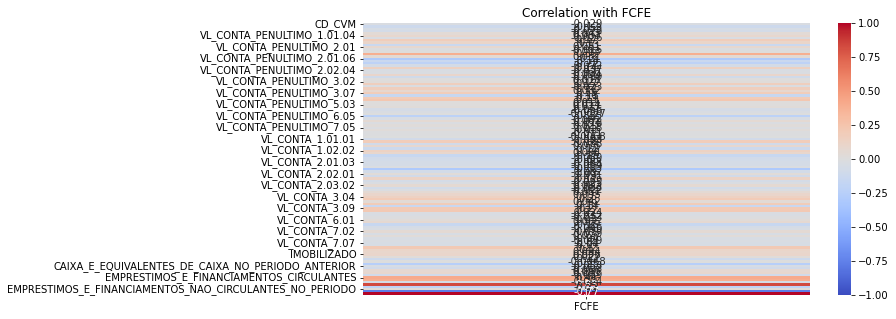

In [35]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame(data)

# Calcular a matriz de correlação
correlation_matrix = df.corr()

# Pegar a correlação de todas as colunas em relação à coluna 'FCFE'
fcfe_corr = correlation_matrix[['FCFE']]

# Plotar a matriz de correlação usando seaborn
plt.figure(figsize=(10, 5))
sns.heatmap(fcfe_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation with FCFE')
plt.show()


#### 5.2.2 Removing Weak Correlations

           DT_FIM_EXERC_PENULTIMO_BP DT_FIM_EXERC_PENULTIMO  PASSIVO_CIRCULANTE  EMPRESTIMOS_E_FINANCIAMENTOS_NAO_CIRCULANTES          FCFE
DT_REFER                                                                                                                                   
2011-03-31                2010-12-31             2010-03-31       -1.556724e+09                                  1.465799e+09 -3.503926e+09
2011-03-31                2010-12-31             2010-03-31       -4.074500e+07                                 -2.620000e+05 -2.236400e+08
2011-06-30                2010-12-31             2010-06-30       -5.038805e+09                                  4.386295e+09 -1.299682e+10
2011-06-30                2010-12-31             2010-06-30       -3.465600e+07                                 -7.730000e+05 -6.029300e+07
2011-09-30                2010-12-31             2010-09-30       -1.665075e+09                                  8.240680e+08 -4.035629e+09
...                 

/tmp/ipykernel_830712/2961070048.py:12: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


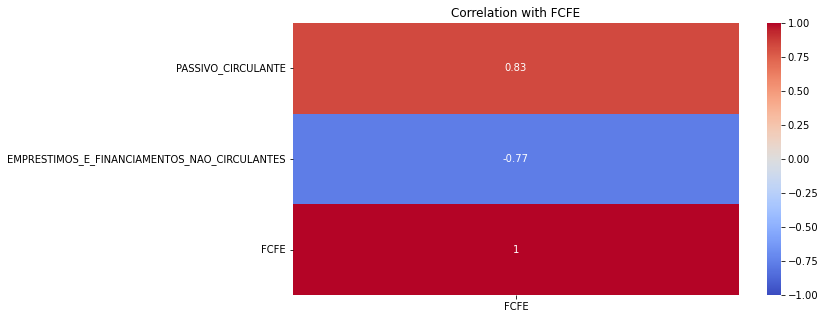

In [36]:
# Identificar colunas com correlação fraca com 'FCFE'
correlation_cut = 0.5
cols_to_drop = fcfe_corr[(fcfe_corr['FCFE'] >= -correlation_cut) & (fcfe_corr['FCFE'] <= correlation_cut)].index

# Remover essas colunas do dataframe
df.drop(columns=cols_to_drop, inplace=True)

# Visualizar o dataframe após a remoção
print(df)

# Calcular a matriz de correlação
correlation_matrix = df.corr()

# Pegar a correlação de todas as colunas em relação à coluna 'FCFE'
fcfe_corr = correlation_matrix[['FCFE']]

# Plotar a matriz de correlação usando seaborn
plt.figure(figsize=(10, 5))
sns.heatmap(fcfe_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation with FCFE')
plt.show()

#### 5.2.3 Correlation Heatmap

In [37]:
%pip install seaborn


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


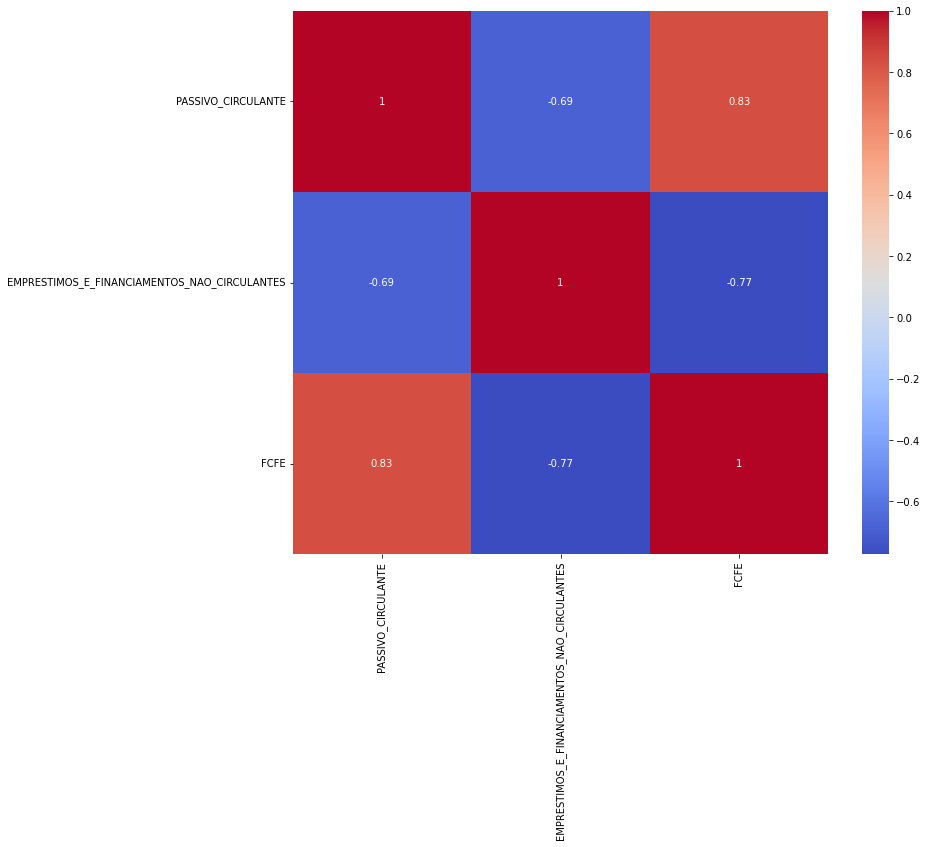

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

### 5.3 Time Series Visualization

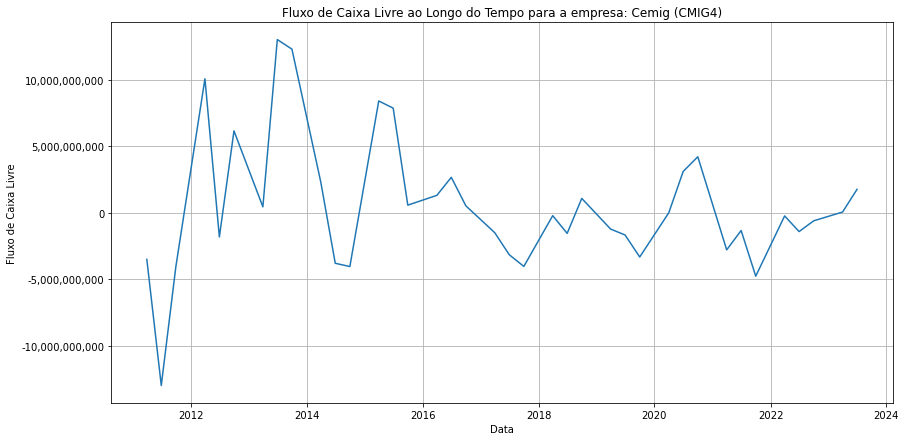

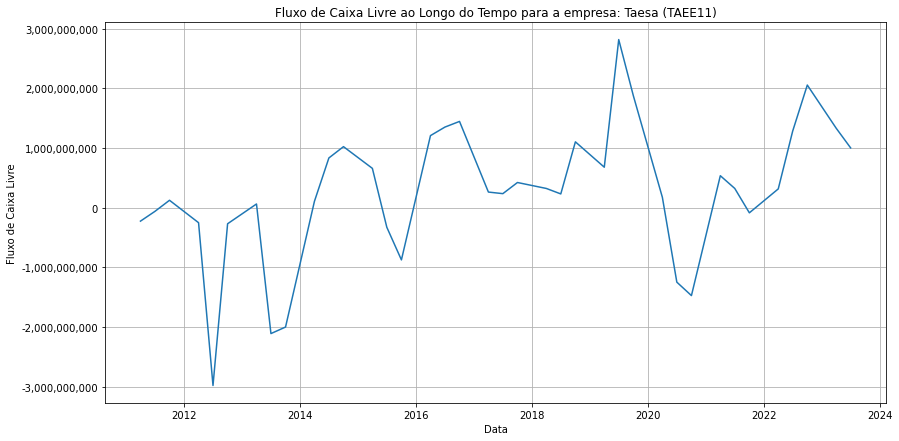

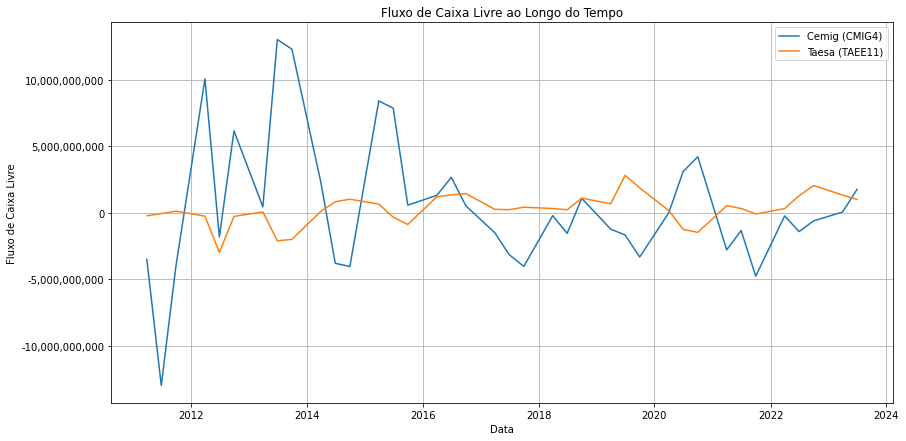

In [39]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

def thousands_formatter(x, pos):
    return f'{int(x):,}'

formatter = FuncFormatter(thousands_formatter)

def print_serie(df, company_code):
    company = companies[company_code]
    plt.figure(figsize=(14,7))
    plt.plot(df.index, df['FCFE'])
    plt.title(f"Fluxo de Caixa Livre ao Longo do Tempo para a empresa: {company['name']} ({company['ticker']})")
    plt.xlabel('Data')
    plt.ylabel('Fluxo de Caixa Livre')
    plt.grid(True)
    plt.ticklabel_format(style='plain', axis='y')
    ax = plt.gca()  # get current axis
    ax.yaxis.set_major_formatter(formatter)  # set the formatter for y axis
    plt.show()

for company_code in companies:
    company_data = data[data['CD_CVM'] == company_code]
    print_serie(company_data, company_code)


def plot_combined_series(data, companies):
    plt.figure(figsize=(14,7))

    for company_code in companies:
        company_data = data[data['CD_CVM'] == company_code]
        company = companies[company_code]
        plt.plot(company_data.index, company_data['FCFE'], label=f"{company['name']} ({company['ticker']})")

    plt.title('Fluxo de Caixa Livre ao Longo do Tempo')
    plt.xlabel('Data')
    plt.ylabel('Fluxo de Caixa Livre')
    plt.legend(loc='best')
    plt.ticklabel_format(style='plain', axis='y')
    ax = plt.gca()  # get current axis
    ax.yaxis.set_major_formatter(formatter)  # set the formatter for y axis
    plt.grid(True)
    plt.show()

plot_combined_series(data, companies)

### 5.4 Time Series Decomposition

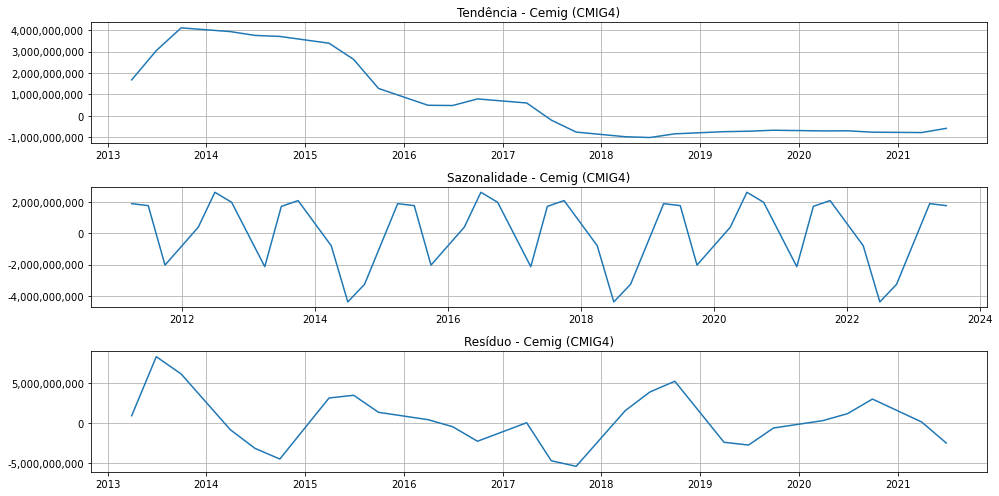

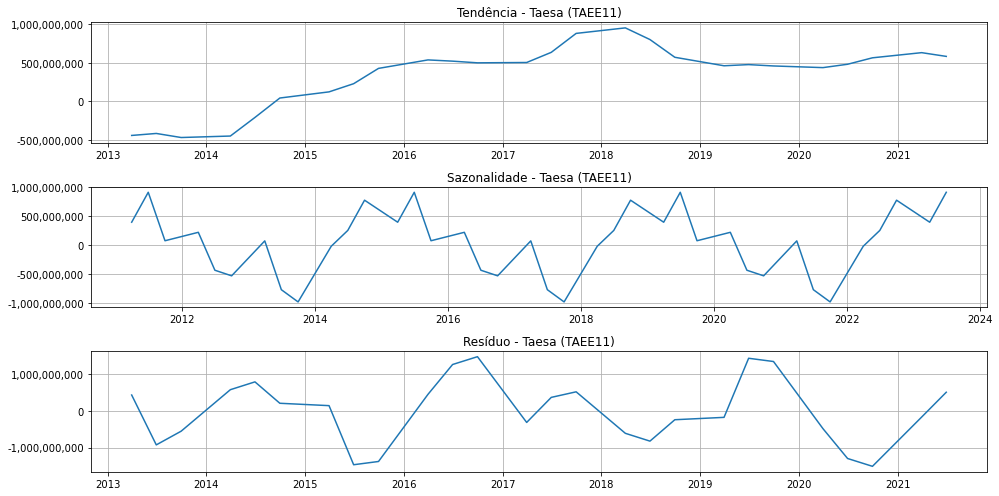

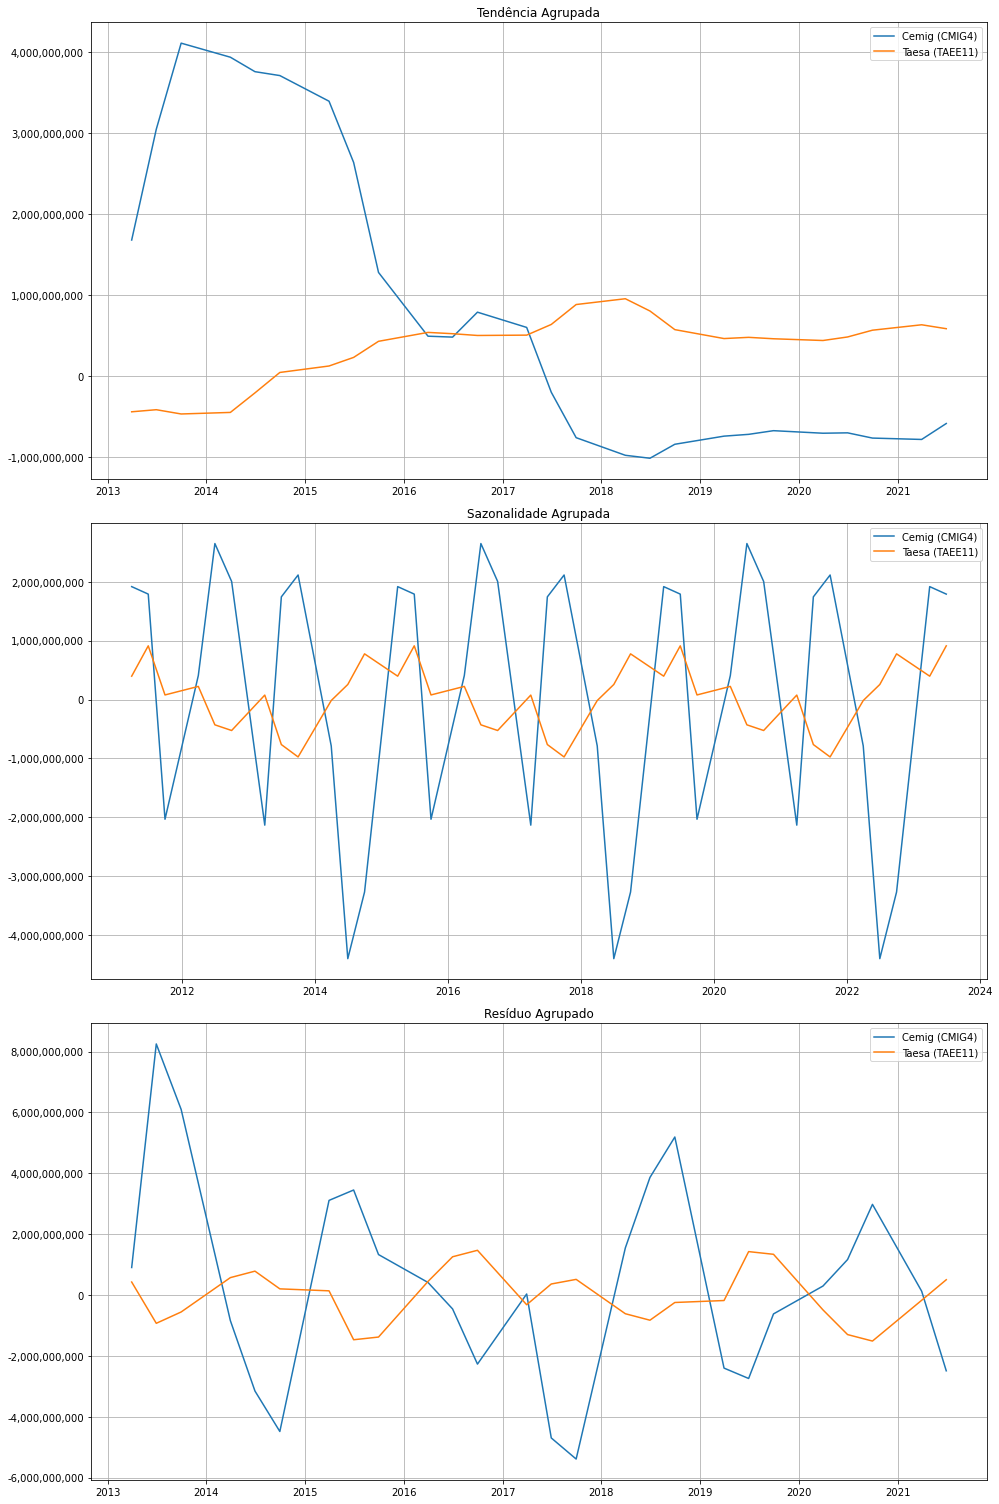

In [40]:
import statsmodels.api as sm
import matplotlib.ticker as ticker

def decompose_series(data, period=12):
    decomposition = sm.tsa.seasonal_decompose(data, period=period)
    return decomposition

def plot_individual_decomposition(data, company_code, period=12):
    company = companies[company_code]
    company_data = data[data['CD_CVM'] == company_code]

    decomposition = decompose_series(company_data['FCFE'], period)

    # Thousand separator
    formatter = ticker.FuncFormatter(lambda x, p: format(int(x), ','))

    plt.figure(figsize=(14, 7))
    plt.subplot(3, 1, 1)
    plt.plot(decomposition.trend)
    plt.title(f"Tendência - {company['name']} ({company['ticker']})")
    plt.grid(True)
    plt.gca().yaxis.set_major_formatter(formatter)

    plt.subplot(3, 1, 2)
    plt.plot(decomposition.seasonal)
    plt.title(f"Sazonalidade - {company['name']} ({company['ticker']})")
    plt.grid(True)
    plt.gca().yaxis.set_major_formatter(formatter)

    plt.subplot(3, 1, 3)
    plt.plot(decomposition.resid)
    plt.title(f"Resíduo - {company['name']} ({company['ticker']})")
    plt.grid(True)
    plt.gca().yaxis.set_major_formatter(formatter)

    plt.tight_layout()
    plt.grid(True)
    plt.show()

for company_code in companies:
    plot_individual_decomposition(data, company_code)



def plot_grouped_decomposition(data, companies, period=12):
    plt.figure(figsize=(14, 21))

    # Thousand separator
    formatter = ticker.FuncFormatter(lambda x, p: format(int(x), ','))

    for company_code in companies:
        company_data = data[data['CD_CVM'] == company_code]
        company = companies[company_code]

        # Serie decomposition
        decomposition = decompose_series(company_data['FCFE'], period)

        # Plotting Tendency
        plt.subplot(3, 1, 1)
        plt.plot(decomposition.trend, label=f"{company['name']} ({company['ticker']})")
        plt.title('Tendência Agrupada')
        plt.legend(loc='best')
        plt.grid(True)
        plt.gca().yaxis.set_major_formatter(formatter)

        # Plotting Tendency Seasonality
        plt.subplot(3, 1, 2)
        plt.plot(decomposition.seasonal, label=f"{company['name']} ({company['ticker']})")
        plt.title('Sazonalidade Agrupada')
        plt.legend(loc='best')
        plt.grid(True)
        plt.gca().yaxis.set_major_formatter(formatter)

        # Plotting Resid
        plt.subplot(3, 1, 3)
        plt.plot(decomposition.resid, label=f"{company['name']} ({company['ticker']})")
        plt.title('Resíduo Agrupado')
        plt.legend(loc='best')
        plt.grid(True)
        plt.gca().yaxis.set_major_formatter(formatter)

    plt.tight_layout()
    plt.grid(True)
    plt.show()

plot_grouped_decomposition(data, companies)

### 5.5 Stationarity validation

**Bibliografy:**

- Dickey, D.A. & Fuller, W.A. (1979). Distribution of the Estimators for Autoregressive Time Series With a Unit Root. Journal of the American Statistical Association, 74(366a), 427-431.

- Kwiatkowski, D., Phillips, P.C.B., Schmidt, P., & Shin, Y. (1992). Testing the null hypothesis of stationarity against the alternative of a unit root. Journal of Econometrics, 54(1-3), 159-178.

- Phillips, P.C.B. & Perron, P. (1988). Testing for a unit root in time series regression. Biometrika, 75(2), 335-346.

In [41]:
%pip install arch

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [42]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller, kpss
from arch.unitroot import PhillipsPerron

P_VALUE = 0.05

def check_stationarity(data):
    # Performing the Augmented Dickey-Fuller test:
    adf_result = adfuller(data)
    adf_statistic, adf_p_value = adf_result[0], adf_result[1]
    print('ADF Statistic:', adf_statistic)
    print('ADF p-value:', adf_p_value)

    # Performing the KPSS test:
    kpss_statistic, kpss_p_value = None, None
    try:
        kpss_result = kpss(data)
        kpss_statistic, kpss_p_value = kpss_result[0], kpss_result[1]
        print('KPSS Statistic:', kpss_statistic)
        print('KPSS p-value:', kpss_p_value)
    except Warning as w:
        print(f"KPSS Warning: {w}")
    
    # Performing the Phillips-Perron test:
    pp_test = PhillipsPerron(data)
    pp_statistic, pp_p_value = pp_test.stat, pp_test.pvalue
    print('Phillips-Perron Statistic:', pp_statistic)
    print('Phillips-Perron p-value:', pp_p_value)

    is_stationary = adf_p_value <= P_VALUE and (kpss_p_value is None or kpss_p_value > P_VALUE) and pp_p_value <= P_VALUE
    if is_stationary:
        print("Conclusão: A série é estacionária.")
    else:
        print("Conclusão: A série NÃO é estacionária.")
    
    return is_stationary

stationary_series_dict = {}
non_stationary_companies = {}

for company_code in companies:
    company_info = companies[company_code]
    company_data = data[data['CD_CVM'] == company_code]
    
    print("\n\n------------------------------------------------------")
    print(f"Resultado para a empresa {company_info['name']} ({company_info['ticker']})")
    print("------------------------------------------------------")
    
    is_stationary = check_stationarity(company_data['FCFE'])
    
    if is_stationary:
        stationary_series_dict[company_code] = company_data['FCFE']
    else:
        non_stationary_companies[company_code] = company_data['FCFE']




------------------------------------------------------
Resultado para a empresa Cemig (CMIG4)
------------------------------------------------------
ADF Statistic: -2.121005979038218
ADF p-value: 0.23615230599249465
KPSS Statistic: 0.17924847912022346
KPSS p-value: 0.1
Phillips-Perron Statistic: -4.151044293280743
Phillips-Perron p-value: 0.0007965546616630513
Conclusão: A série NÃO é estacionária.


------------------------------------------------------
Resultado para a empresa Taesa (TAEE11)
------------------------------------------------------
ADF Statistic: -3.6637315103740455
ADF p-value: 0.004653210067364007
KPSS Statistic: 0.44292022656683977
KPSS p-value: 0.05865507475567252
Phillips-Perron Statistic: -3.2117118222989913
Phillips-Perron p-value: 0.019316683436219163
Conclusão: A série é estacionária.


/tmp/ipykernel_830712/592419748.py:17: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(data)


### 5.6 Non-stationarity transformations


Transformando série para a empresa Cemig (CMIG4)



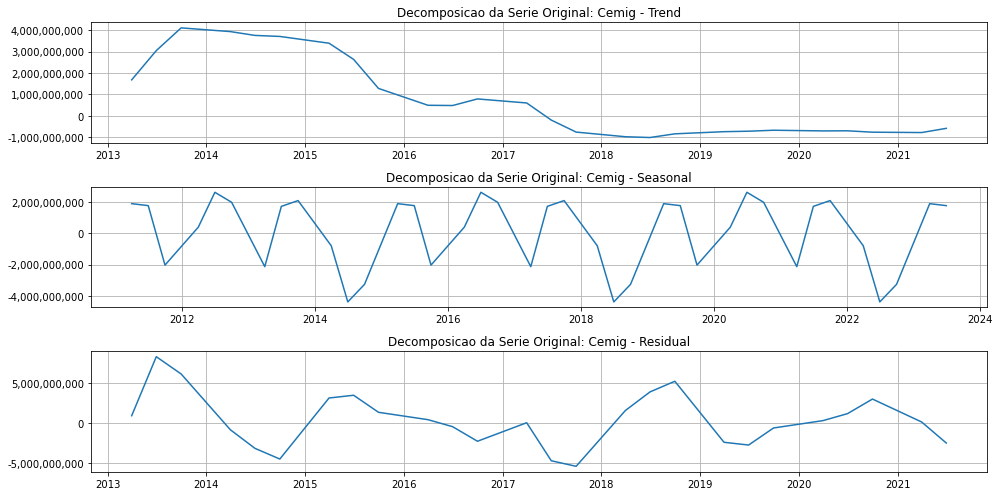


Validando Pós Transformação para a empresa Cemig (CMIG4)

ADF Statistic: -6.908425393226508
ADF p-value: 1.230055973744182e-09
KPSS Statistic: 0.22923265976703536
KPSS p-value: 0.1
Phillips-Perron Statistic: -9.444623957542017
Phillips-Perron p-value: 4.79239643285024e-16
Conclusão: A série é estacionária.


/tmp/ipykernel_830712/592419748.py:17: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(data)


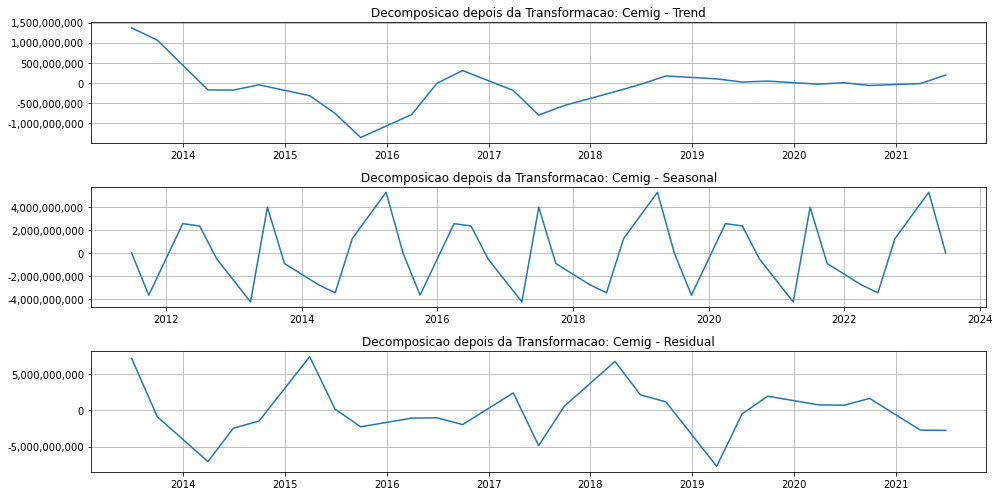

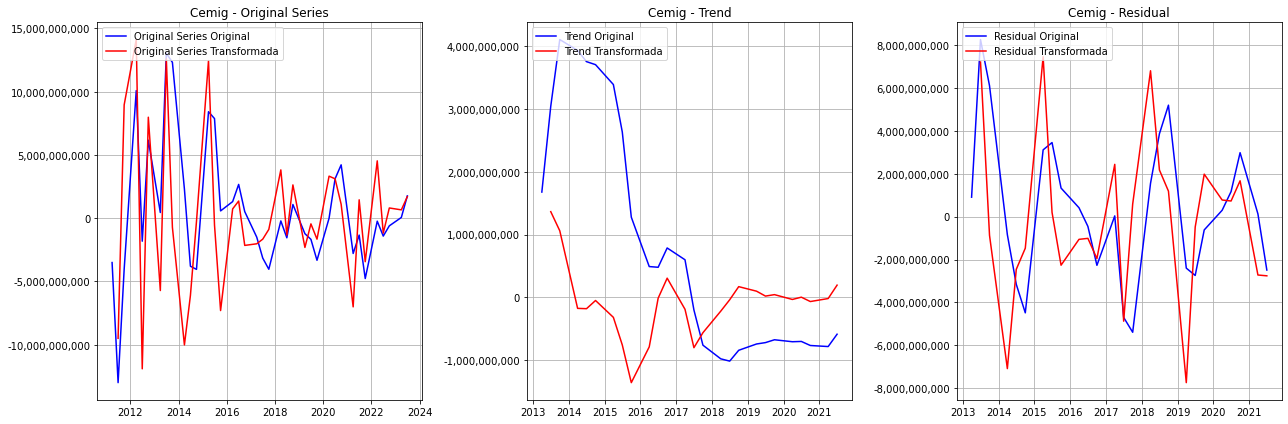

{20257: DT_REFER
2011-03-31   -2.236400e+08
2011-06-30   -6.029300e+07
2011-09-30    1.258190e+08
2012-03-31   -2.497250e+08
2012-06-30   -2.976806e+09
2012-09-30   -2.674410e+08
2013-03-31    6.384600e+07
2013-06-30   -2.107089e+09
2013-09-30   -1.997382e+09
2014-03-31    1.083010e+08
2014-06-30    8.346630e+08
2014-09-30    1.024113e+09
2015-03-31    6.604940e+08
2015-06-30   -3.260470e+08
2015-09-30   -8.727450e+08
2016-03-31    1.209064e+09
2016-06-30    1.351834e+09
2016-09-30    1.446793e+09
2017-03-31    2.634070e+08
2017-06-30    2.369750e+08
2017-09-30    4.235520e+08
2018-03-31    3.238250e+08
2018-06-30    2.323260e+08
2018-09-30    1.104718e+09
2019-03-31    6.801710e+08
2019-06-30    2.817749e+09
2019-09-30    1.878120e+09
2020-03-31    1.746390e+08
2020-06-30   -1.245390e+09
2020-09-30   -1.470767e+09
2021-03-31    5.373740e+08
2021-06-30    3.242310e+08
2021-09-30   -8.423000e+07
2022-03-31    3.163420e+08
2022-06-30    1.285921e+09
2022-09-30    2.055922e+09
2023-03-31 

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import matplotlib.ticker as ticker


def adfuller_test(series):
    result = adfuller(series)
    return result[1] <= P_VALUE


def decompose_series(data, period=12):
    return sm.tsa.seasonal_decompose(data, period=period)


def plot_decomposition(series, title):
    plt.figure(figsize=(14, 7))
    formatter = ticker.FuncFormatter(lambda x, p: format(int(x), ','))

    decomposition = decompose_series(series)

    components = [('Trend', decomposition.trend), ('Seasonal', decomposition.seasonal), ('Residual', decomposition.resid)]
    for i, (label, component) in enumerate(components, 1):
        plt.subplot(3, 1, i)
        plt.plot(component)
        plt.title(f"{title} - {label}")
        plt.grid(True)
        plt.gca().yaxis.set_major_formatter(formatter)

    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_overlaid_decomposition(original_series, transformed_series, title):
    """Plot the overlaid original, trend, and residual decomposition of two time series."""
    orig_decomposition = decompose_series(original_series)
    trans_decomposition = decompose_series(transformed_series)

    plt.figure(figsize=(18, 6))
    formatter = ticker.FuncFormatter(lambda x, p: format(int(x), ','))

    components = [('Original Series', original_series, transformed_series),
                  ('Trend', orig_decomposition.trend, trans_decomposition.trend),
                  ('Residual', orig_decomposition.resid, trans_decomposition.resid)]

    for i, (label, orig_component, trans_component) in enumerate(components, 1):
        plt.subplot(1, 3, i)
        plt.plot(orig_component.index, orig_component, label=f'{label} Original', color='blue')
        plt.plot(trans_component.index, trans_component, label=f'{label} Transformada', color='red')
        plt.title(f"{title} - {label}")
        plt.legend(loc='upper left')
        plt.grid(True)
        plt.gca().yaxis.set_major_formatter(formatter)

    plt.grid(True)
    plt.tight_layout()
    plt.show()

def make_series_stationary(series, max_diff=2):
    stationary_series = series.copy()
    for _ in range(max_diff):
        stationary_series = stationary_series.diff().dropna()
        if adfuller_test(stationary_series):
            return stationary_series
    return None


def main():
    for company_code, company_series in non_stationary_companies.items():
        company_info = companies[company_code]
        company_data = data[data['CD_CVM'] == company_code]['FCFE']

        print(f"\nTransformando série para a empresa {company_info['name']} ({company_info['ticker']})\n")

        # Plot original series
        plot_decomposition(company_data, title=f"Decomposicao da Serie Original: {company_info['name']}")

        # Making the series stationary
        stationary_series = make_series_stationary(company_data)

        print(f"\nValidando Pós Transformação para a empresa {company_info['name']} ({company_info['ticker']})\n")
        check_stationarity(stationary_series)

        if stationary_series is not None:
            # Plot transformed series
            plot_decomposition(stationary_series, title=f"Decomposicao depois da Transformacao: {company_info['name']}")

            stationary_series_dict[company_code] = stationary_series
            plot_overlaid_decomposition(company_data, stationary_series, company_info['name'])


if __name__ == "__main__":
    main()


print(stationary_series_dict)

### 5.7 Predictions

#### 5.7.1 Prediction using ARIMA

**ARIMA (Autoregressive Integrated Moving Average)**

It is a widely-used approach for time series forecasting. The model relies on three main components:

- **Autoregression (AR):** Refers to the relationship between an observation and a number of lagged observations.
- **Integrated (I):** Refers to the use of differencing to make the time series stationary.
- **Moving Average (MA):** Uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.

**Source:**
- Box, G. E., Jenkins, G. M., Reinsel, G. C., & Ljung, G. M. (2015). *Time series analysis: forecasting and control*. John Wiley & Sons.

#### 5.7.2 Prediction using SARIMA

**SARIMA (Seasonal Autoregressive Integrated Moving Average)**

SARIMA adds an additional seasonal component to the ARIMA model, making it suitable for time series with clear seasonal patterns. The components of SARIMA are:

- **Seasonal Autoregression (SAR):** Refers to the relationship between an observation and a number of seasonally lagged observations.
- **Seasonal Integrated (SI):** Uses seasonal differencing to make the series stationary.
- **Seasonal Moving Average (SMA):** Uses the dependency between an observation and a residual error from a moving average model applied to seasonally lagged observations.

**Source:**
- Hyndman, R. J., & Athanasopoulos, G. (2018). *Forecasting: principles and practice*. OTexts.


#### 5.7.3 Prediction using XGBoost

**XGBoost (Extreme Gradient Boosting)**

XGBoost, short for "Extreme Gradient Boosting", is a decision-tree-based ensemble Machine Learning algorithm. It uses a gradient boosting framework. XGBoost is especially known for its speed and performance. For time series forecasting, it works best when combined with time-based features and lagged values of the series to be predicted.

- **Tree-based Modeling:** At its core, XGBoost constructs decision trees like other boosting algorithms, such as Gradient Boosting Machines (GBM).
- **Regularization:** XGBoost includes L1 (Lasso Regression) and L2 (Ridge Regression) regularization which prevents the model from overfitting.
- **Parallel Processing:** It's known for its performance; it's parallel and distributed computing makes it incredibly fast.

**Source:**
- Chen, T., & Guestrin, C. (2016, August). *Xgboost: A scalable tree boosting system*. In Proceedings of the 22nd ACM SIGKDD international conference on knowledge discovery and data mining (pp. 785-794).

#### 5.7.4 Prediction using LSTM

**LSTM (Long Short-Term Memory)**

LSTM is a special kind of Recurrent Neural Network (RNN) architecture optimized for sequences and time series data. Unlike traditional RNNs which struggle to learn and retain long-term dependencies due to issues like vanishing gradient, LSTMs are explicitly designed to avoid long-term dependency issues. The key features of LSTM are:

- **Memory Cell:** At its core, LSTM has a cell state, often referred to as the "memory cell", which can maintain its state over time, acting somewhat like a conveyor belt. It allows information to be passed down unchanged if needed.

- **Gates:** LSTMs have three gates to control the cell state and output:
  1. **Forget Gate:** Decides what information should be discarded or kept.
  2. **Input Gate:** Updates the cell state with new information.
  3. **Output Gate:** Determines the output based on the cell state and the input.

By virtue of these gates and the memory cell, LSTMs can model and predict patterns in time series and sequences over long periods effectively, making them popular for many sequence prediction problems.

**Sources:**
- Hochreiter, S., & Schmidhuber, J. (1997). *Long short-term memory*. Neural computation, 9(8), 1735-1780.
- Goodfellow, I., Bengio, Y., & Courville, A. (2016). *Deep Learning*. MIT Press. [Online version available](http://www.deeplearningbook.org/)


In [44]:
%pip install xgboost


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



forecast_steps: 731



 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.69459D+01    |proj g|=  2.66155D+00

At iterate    5    f=  1.61885D+01    |proj g|=  7.79346D-02

At iterate   10    f=  1.61388D+01    |proj g|=  9.01258D-02

At iterate   15    f=  1.61137D+01    |proj g|=  2.85212D-02

At iterate   20    f=  1.61082D+01    |proj g|=  7.23968D-03

At iterate   25    f=  1.61075D+01    |proj g|=  1.02889D-03

At iterate   30    f=  1.61072D+01    |proj g|=  1.56093D-02

At iterate   35    f=  1.61054D+01    |proj g|=  3.04906D-04

At iterate   40    f=  1.61054D+01    |proj g|=  5.38130D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

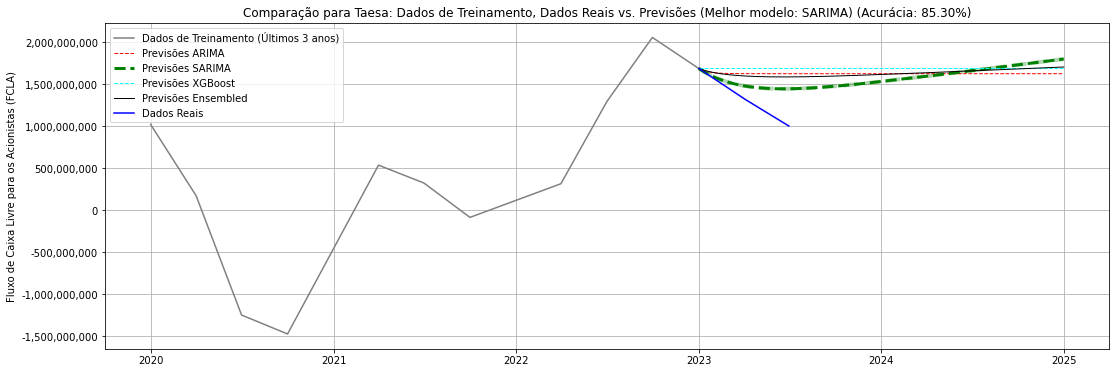


forecast_steps: 731



 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.07428D+01    |proj g|=  5.78936D+01

At iterate    5    f=  1.87583D+01    |proj g|=  3.38935D-01

At iterate   10    f=  1.87571D+01    |proj g|=  7.67795D-02

At iterate   15    f=  1.87376D+01    |proj g|=  2.43300D-01

At iterate   20    f=  1.87312D+01    |proj g|=  3.75018D-01

At iterate   25    f=  1.87239D+01    |proj g|=  2.27800D-02

At iterate   30    f=  1.87194D+01    |proj g|=  2.28257D-01

At iterate   35    f=  1.86914D+01    |proj g|=  3.40112D-02

At iterate   40    f=  1.86737D+01    |proj g|=  5.18531D-02

At iterate   45    f=  1.86626D+01    |proj g|=  9.01368D-03


/home/enok/.local/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  1.86594D+01    |proj g|=  1.48032D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     58      1     0     0   1.480D-02   1.866D+01
  F =   18.659426030004870     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA error: 393563390.96353257
SARIMA error: 386972232.4714989
XGBoost error: 382825991.32239586
Ensemble error: 387613633.7609834

Para a empresa Cemig:
RMSE ARIMA: 393563390.96 - 80.21%
RMSE SARIMA: 386972232.47 - 81.22%
RMSE XGBoost: 382825991.32 - 79.66%
RMSE Ensembled: 387613633.76 - 80.38%


Melhor modelo: XGBoost
Acurácia do modelo vencedor: 79.66%



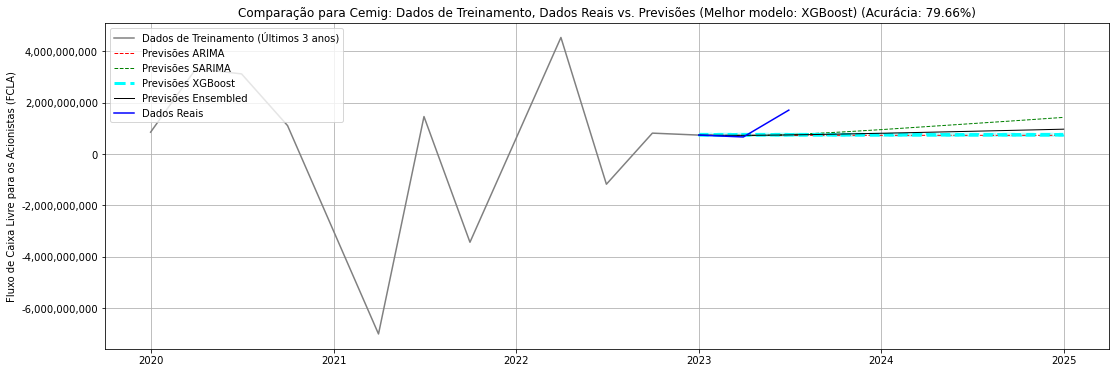

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
from keras.models import Sequential
from keras.layers import Dense, LSTM

def arima_forecast(train_series, steps):
    model = ARIMA(train_series, order=(1,1,1))
    fit_model = model.fit()
    predictions = fit_model.forecast(steps=steps)
    return predictions

def sarima_forecast(train_series, steps):
    model = SARIMAX(train_series, order=(1,1,1), seasonal_order=(1,1,1,4))
    fit_model = model.fit()
    predictions = fit_model.forecast(steps=steps)
    return predictions

def xgboost_forecast(train, steps):
    train_data = pd.DataFrame(train)
    train_data["lag1"] = train_data.shift(1)
    train_data.dropna(inplace=True)

    X = train_data["lag1"].values.reshape(-1, 1)
    y = train_data[train_data.columns[0]].values

    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
    model.fit(X, y)

    forecasts = []
    current_step = train[-1]
    for _ in range(steps):
        forecast = model.predict(np.array([[current_step]]))
        forecasts.append(forecast[0])
        current_step = forecast[0]

    return np.array(forecasts)


# Função para calcular RMSE
def calculate_rmse(true_values, predicted_values):
    return np.sqrt(mean_squared_error(true_values, predicted_values))

# Função para calcular o MAPE
def calculate_mape(true_values, predicted_values):
    return np.mean(np.abs((true_values - predicted_values) / true_values)) * 100

# def plot_ensemble_forecasts(train_series, test_series, arima_preds, preds_sarima, preds_xgboost, preds_lstm, preds_ensemble, company_name, best_model, accuracy):
def plot_ensemble_forecasts(train_series, test_series, arima_preds, preds_sarima, preds_xgboost, preds_ensemble, company_name, best_model, accuracy):
    plt.figure(figsize=(18, 6))

    # Limitando os dados de treinamento para os últimos 3 anos
    three_years_ago = pd.Timestamp(train_series.index[-1] - pd.DateOffset(years=3))
    limited_train_series = train_series[three_years_ago:]

    plt.plot(limited_train_series.index, limited_train_series.values, label='Dados de Treinamento (Últimos 3 anos)', color='grey')

    # Criando o índice para as previsões
    forecast_start = train_series.index[-1] + pd.DateOffset(days=1)
    forecast_end = forecast_start + pd.DateOffset(days=len(arima_preds)-1)
    forecast_index = pd.date_range(forecast_start, forecast_end, freq='D')

    # Plotando o brilho para a linha do modelo vencedor
    glow_width = 4
    lw_arima, lw_sarima, lw_xgboost, lw_ensemble = 1, 1, 1, 1
    if best_model == "ARIMA":
        lw_arima = 3
        plt.plot(forecast_index, arima_preds, color='red', linestyle='--', linewidth=glow_width, alpha=0.3)
    elif best_model == "SARIMA":
        lw_sarima = 3
        plt.plot(forecast_index, preds_sarima, color='green', linestyle='--', linewidth=glow_width, alpha=0.3)
    elif best_model == "XGBoost":
        lw_xgboost = 3
        plt.plot(forecast_index, preds_xgboost, color='cyan', linestyle='--', linewidth=glow_width, alpha=0.3)
    else:
        lw_ensemble = 3
        plt.plot(forecast_index, preds_ensemble, color='black', linestyle='-', linewidth=glow_width, alpha=0.3)

    # Plotando as linhas regulares
    plt.plot(forecast_index, arima_preds, label='Previsões ARIMA', color='red', linestyle='--', linewidth=lw_arima)
    plt.plot(forecast_index, preds_sarima, label='Previsões SARIMA', color='green', linestyle='--', linewidth=lw_sarima)
    plt.plot(forecast_index, preds_xgboost, label='Previsões XGBoost', color='cyan', linestyle='--', linewidth=lw_xgboost)
    plt.plot(forecast_index, preds_ensemble, label='Previsões Ensembled', color='black', linestyle='-', linewidth=lw_ensemble)
    plt.plot(test_series.index, test_series.values, label='Dados Reais', color='blue')

    plt.ylabel('Fluxo de Caixa Livre para os Acionistas (FCLA)')

    plt.legend(loc='upper left')
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
    plt.title(f"Comparação para {company_name}: Dados de Treinamento, Dados Reais vs. Previsões (Melhor modelo: {best_model}) (Acurácia: {accuracy:.2f}%)")
    plt.grid(True)
    plt.show()

# Iterando sobre as empresas e fazendo as previsões
for company_code, series in stationary_series_dict.items():
    company_name = companies[company_code]['name']
    series = series.asfreq('D').interpolate(method='linear')
    series = series.asfreq('D')

    # Aqui está a mudança: Definindo o ponto de divisão para treinamento até o final de 2022 (2022-12-31)
    split_date = pd.to_datetime(str((year_interval_end-1)) + "-12-31")
    
    train_series = series.loc[:split_date]
    # O conjunto de testes agora será para o ano de 2023
    test_series = series.loc[(split_date + pd.DateOffset(days=1)):]

    # Verificação de validação:
    if len(train_series) == 0:
        print(f"[ERRO] A série de treinamento para a empresa {company_name} está vazia.")
        continue

    if len(test_series) == 0:
        print(f"[ERRO] A série de teste para a empresa {company_name} está vazia.")
        continue

    # Forecasts individuais
    # (2024-12-31) - (2022-12-31) = 2 years = 2 * 365 = 730
    forecast_steps = (pd.to_datetime(str(year_interval_end+1) + "-12-31") - split_date).days
    print(f'\nforecast_steps: {forecast_steps}\n')

    preds_arima = arima_forecast(train_series.values, forecast_steps)
    preds_sarima = sarima_forecast(train_series.values, forecast_steps)
    preds_xgboost = xgboost_forecast(train_series.values, forecast_steps)

    # Ensemble forecast
    preds_ensemble = (preds_arima + preds_sarima + preds_xgboost) / 3

    # Calculando erros
    # Note que agora estamos apenas avaliando o erro nos anos de 2023 e 2024
    rmse_arima = calculate_rmse(test_series.values, preds_arima[:len(test_series)])
    print(f'ARIMA error: {rmse_arima}')
    rmse_sarima = calculate_rmse(test_series.values, preds_sarima[:len(test_series)])
    print(f'SARIMA error: {rmse_sarima}')
    rmse_xgboost = calculate_rmse(test_series.values, preds_xgboost[:len(test_series)])
    print(f'XGBoost error: {rmse_xgboost}')
    rmse_ensemble = calculate_rmse(test_series.values, preds_ensemble[:len(test_series)])
    print(f'Ensemble error: {rmse_ensemble}')

    best_rmse = min(rmse_arima, rmse_sarima, rmse_xgboost, rmse_ensemble)

    # Accuracy
    mape_arima = calculate_mape(test_series, preds_arima[:len(test_series)])
    mape_sarima = calculate_mape(test_series, preds_sarima[:len(test_series)])
    mape_xgboost = calculate_mape(test_series, preds_xgboost[:len(test_series)])
    mape_ensemble = calculate_mape(test_series, preds_ensemble[:len(test_series)])

    accuracy_arima = 100 - mape_arima
    accuracy_sarima = 100 - mape_sarima
    accuracy_xgboost = 100 - mape_xgboost
    accuracy_ensemble = 100 - mape_ensemble

    if best_rmse == rmse_arima:
        best_model = "ARIMA"
        accuracy = accuracy_arima
    elif best_rmse == rmse_sarima:
        best_model = "SARIMA"
        accuracy = accuracy_sarima
    elif best_rmse == rmse_xgboost:
        best_model = "XGBoost"
        accuracy = accuracy_xgboost
    else:
        best_model = "Ensemble"
        accuracy = accuracy_ensemble

    print(f"\nPara a empresa {company_name}:")
    print(f"RMSE ARIMA: {rmse_arima:.2f} - {accuracy_arima:.2f}%")
    print(f"RMSE SARIMA: {rmse_sarima:.2f} - {accuracy_sarima:.2f}%")
    print(f"RMSE XGBoost: {rmse_xgboost:.2f} - {accuracy_xgboost:.2f}%")
    print(f"RMSE Ensembled: {rmse_ensemble:.2f} - {accuracy_ensemble:.2f}%")
    print("\n")
    print(f"Melhor modelo: {best_model}")
    print(f"Acurácia do modelo vencedor: {accuracy:.2f}%\n")

    plot_ensemble_forecasts(train_series, test_series, preds_arima, preds_sarima, preds_xgboost, preds_ensemble, company_name, best_model, accuracy)
